<a href="https://colab.research.google.com/github/gopala-goyal/pump-it-up-water-table/blob/main/Pump_It_Up_Data_Mining_the_Water_Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMA - 869 - Machine Learning

## [Pump it Up - Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/)

### Hosted by DataDriven

## Team Alfred
- Sushant Karmakar
- Sushil Megharaj
- Jacqueline Mak
- Faiza Shallwani
- Crystal Fang
- Eddie Wang 
- Gopala Goyal

### Environment Setup

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from category_encoders import TargetEncoder
import sweetviz as sv
import re
%matplotlib inline

### Import Data

In [4]:
df_ = pd.read_csv("https://raw.githubusercontent.com/gopala-goyal/pump-it-up-water-table/main/training_set_values.csv", parse_dates = ['date_recorded'])
df_lab_ = pd.read_csv("https://raw.githubusercontent.com/gopala-goyal/pump-it-up-water-table/main/training_set_labels.csv")

In [ ]:
df_.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal standpipe multiple    communal standpipe  
3  groundwater  communal standpipe multiple    communal standpipe 

# Exploration

In [ ]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55765 non-null  object        
 4   gps_height             59400 non-null  int64         
 5   installer              55745 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59400 non-null  object        
 9   num_private            59400 non-null  int64         
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  region                 59400 non-null  object        
 13  r

In [ ]:
df_.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649    471.482176   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year  
count       59400.000000  
mean         1300.652475  
std           951.620547  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

In [ ]:
df_.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Exploration using Sweetviz - Before Cleaning

In [ ]:
df_['geometry'] = df_['geometry'].astype(str)
my_report = sv.analyze(df_)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



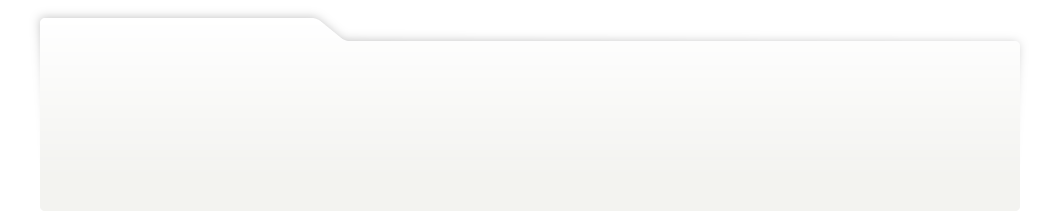
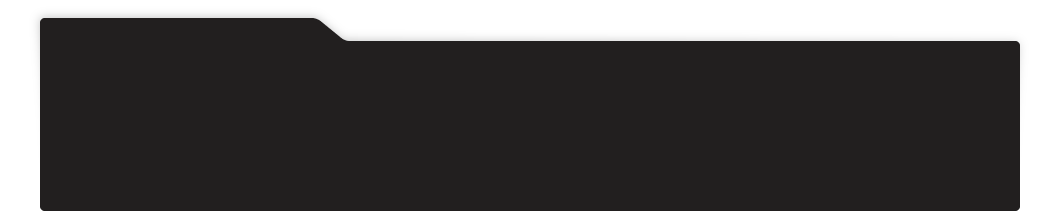
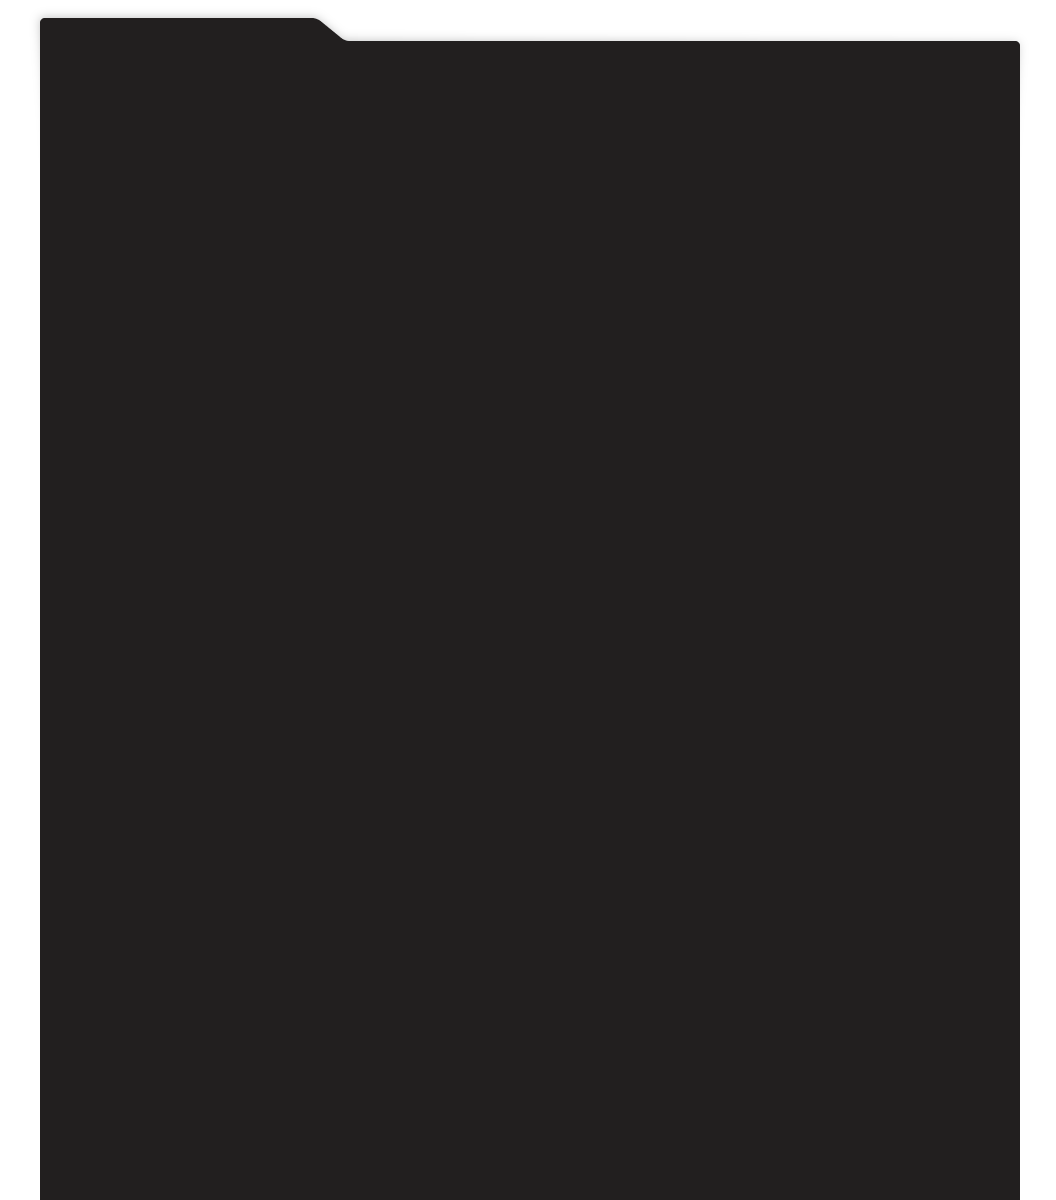
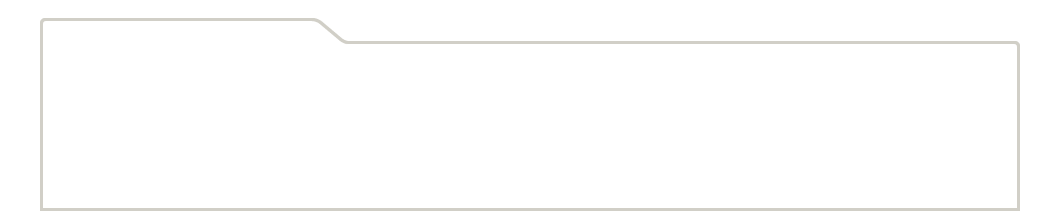
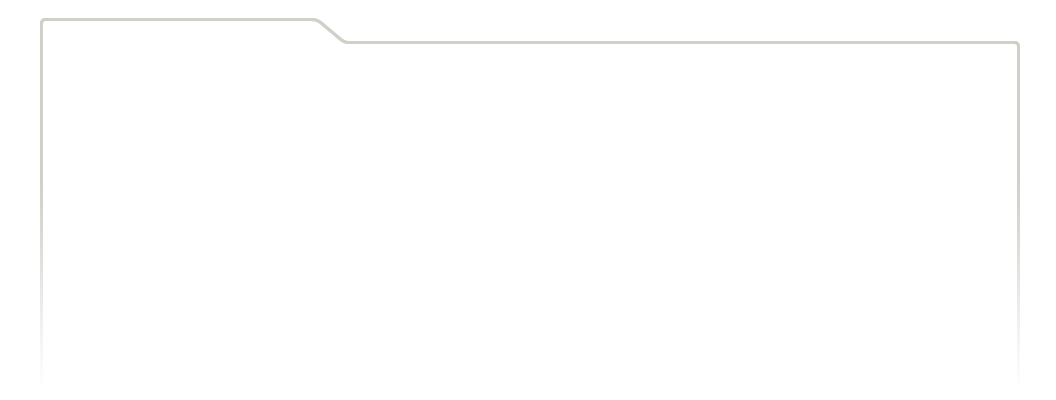
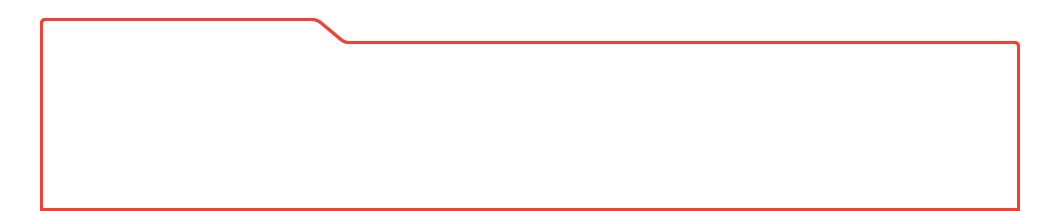
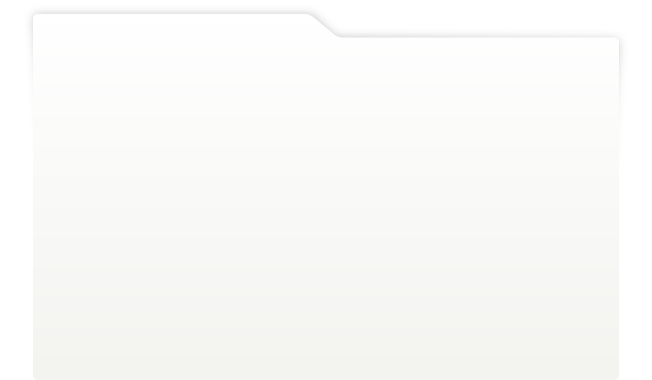
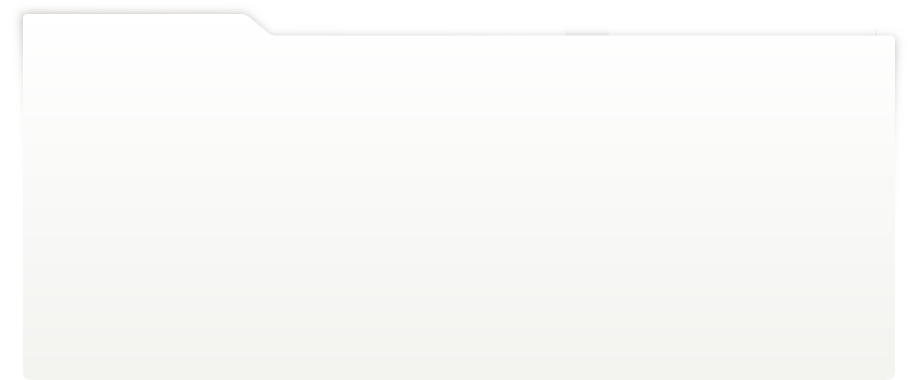
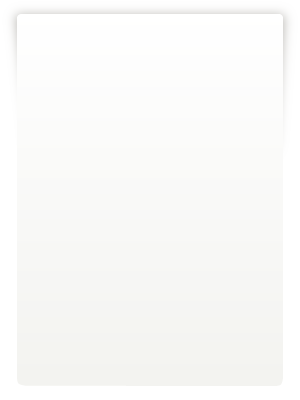
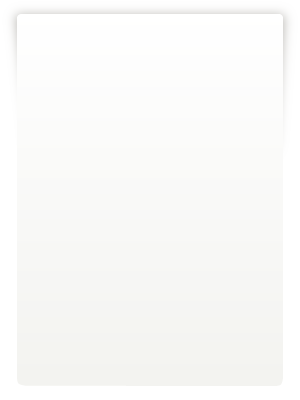
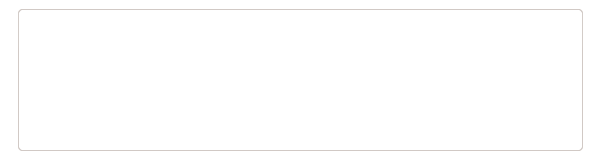
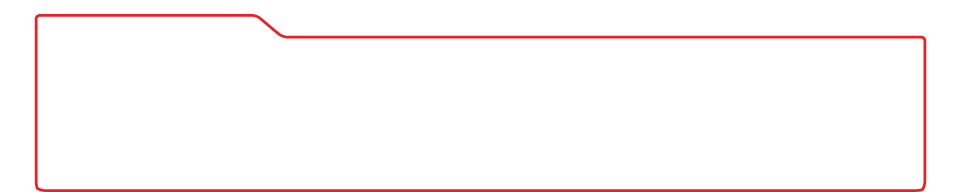
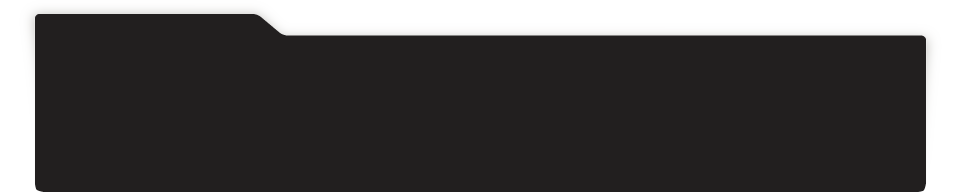
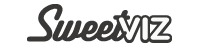
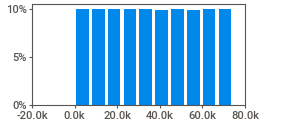
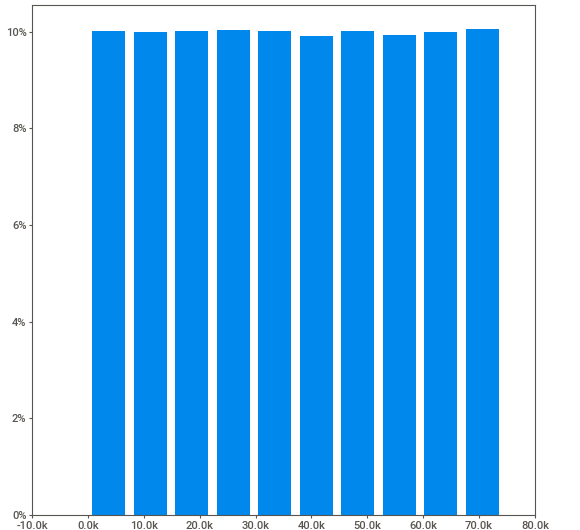
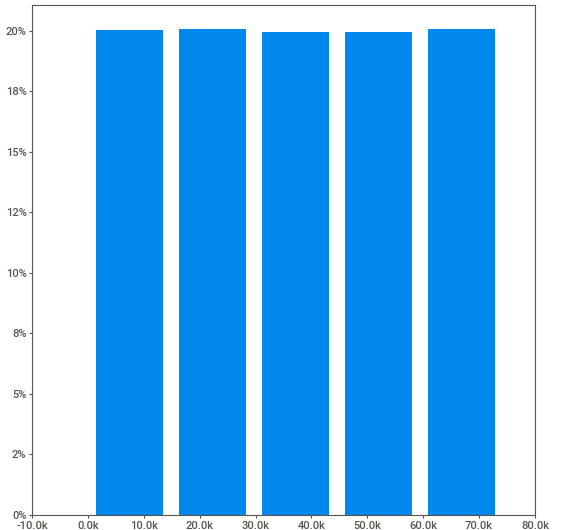
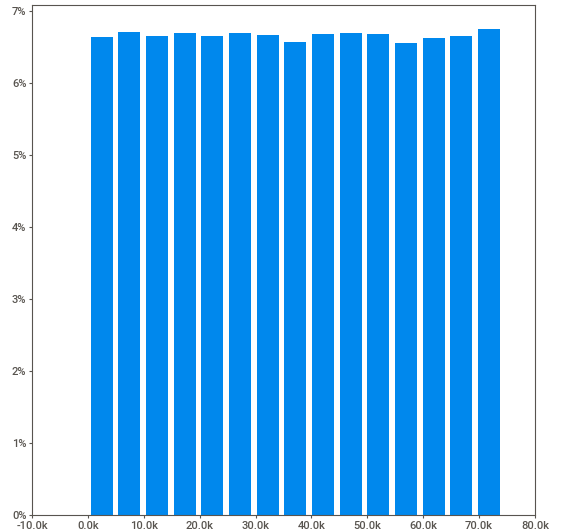
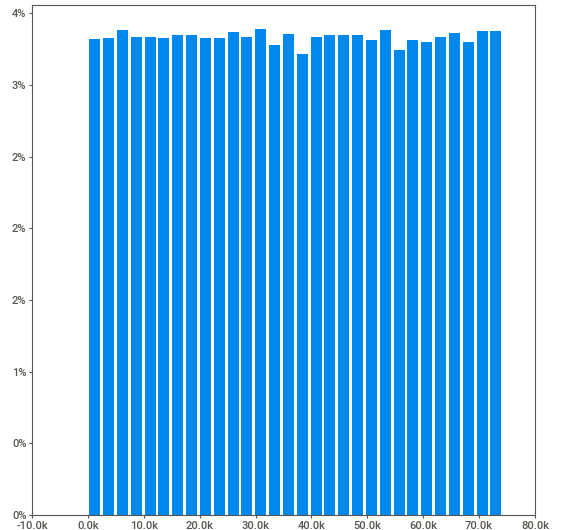
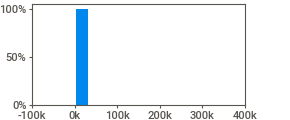
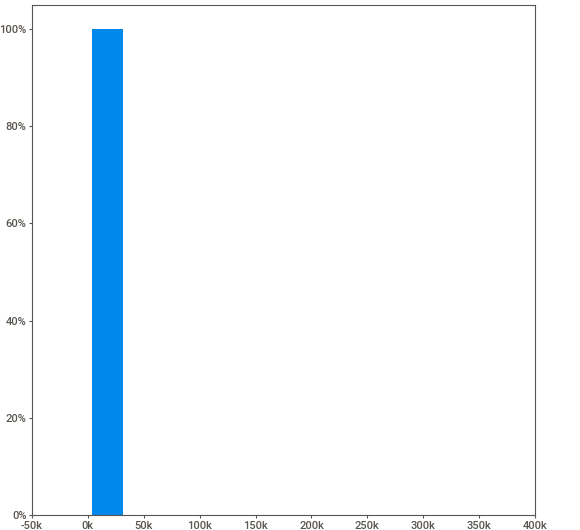
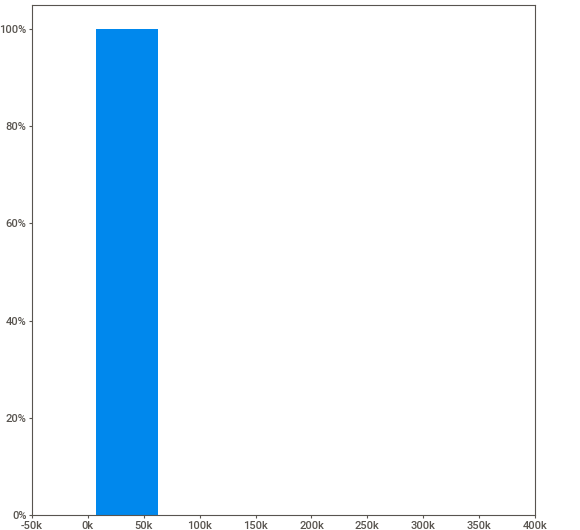
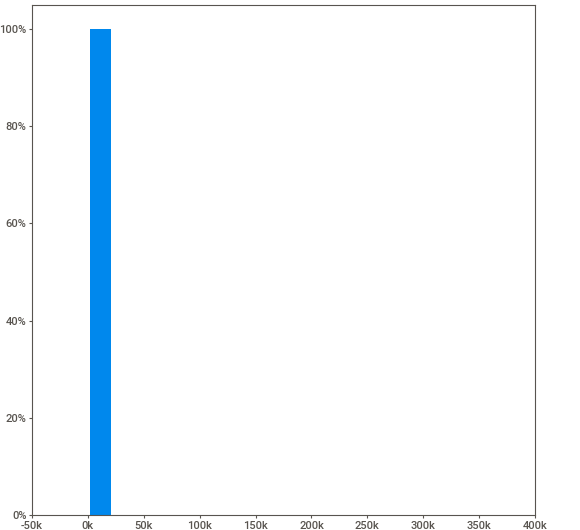
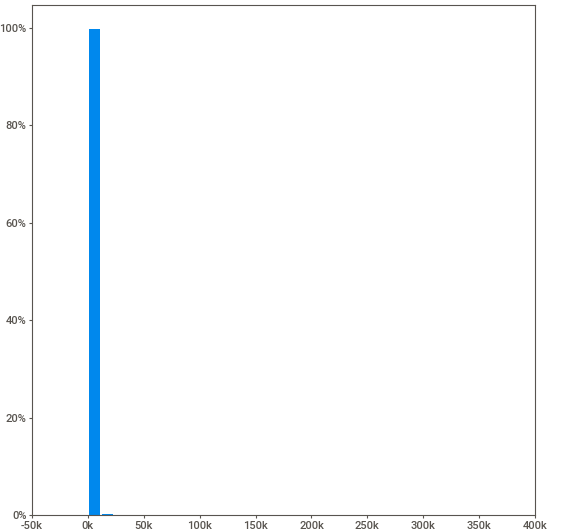
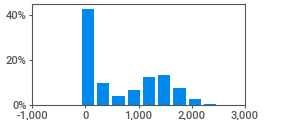
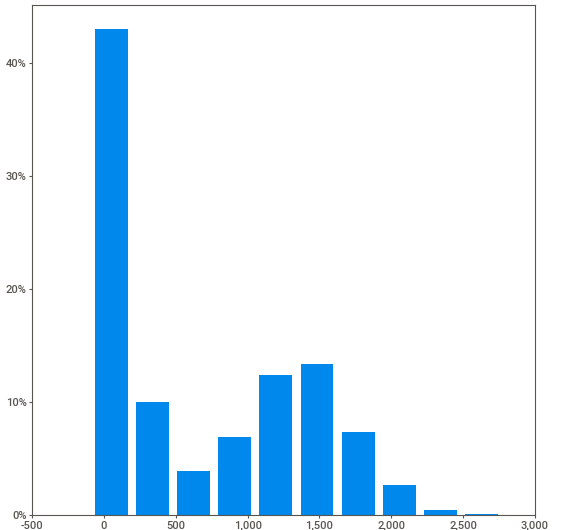
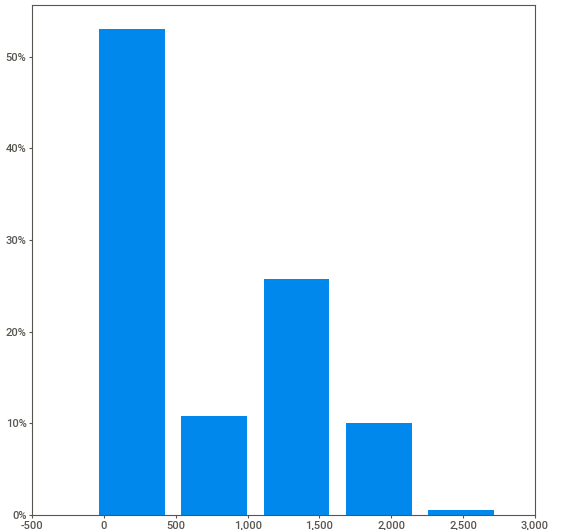
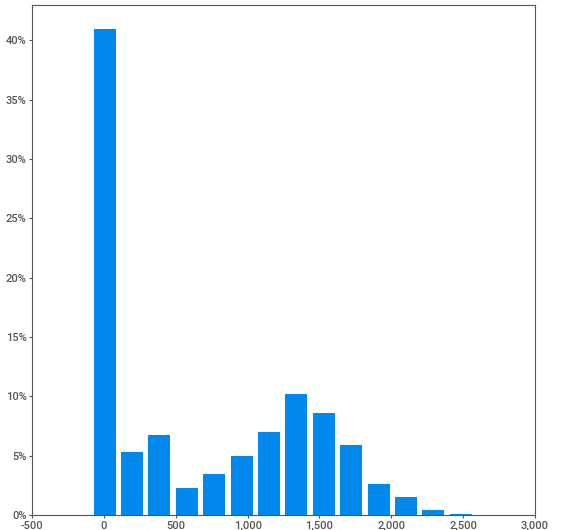
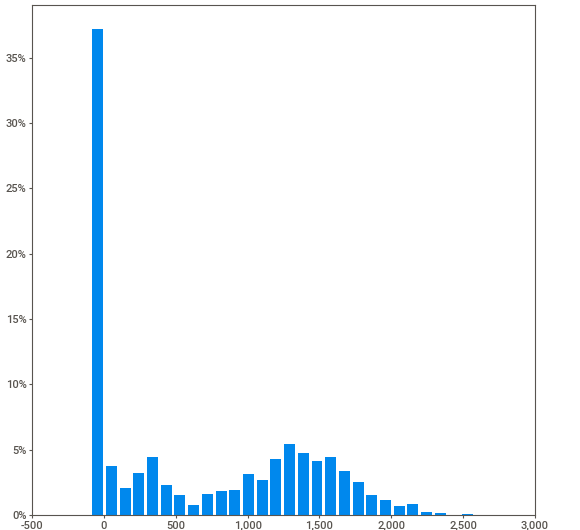
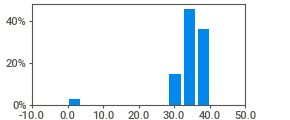
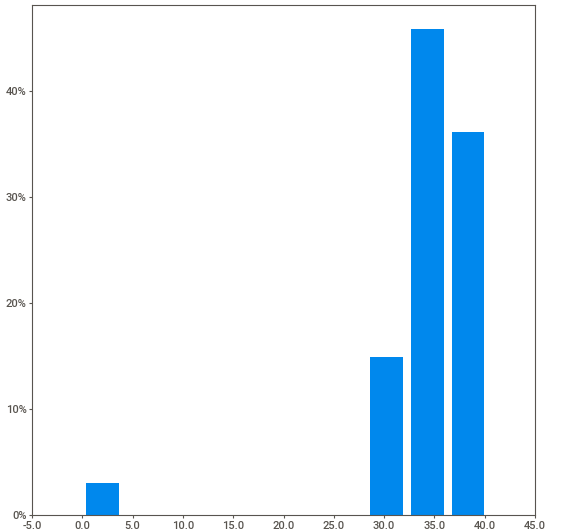
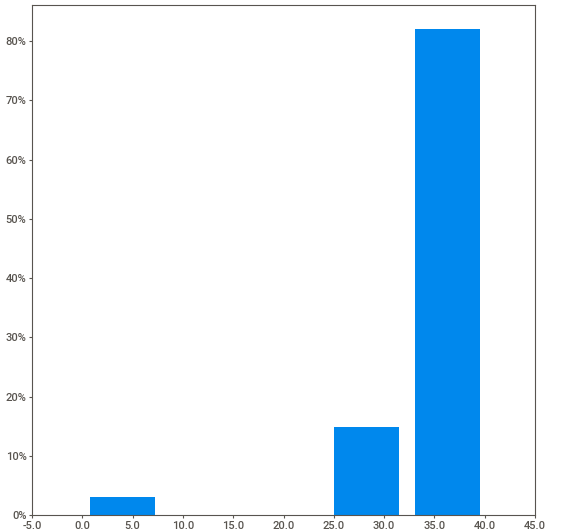
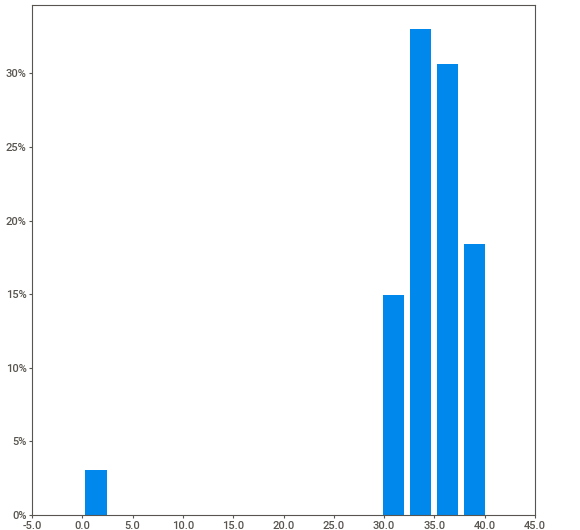
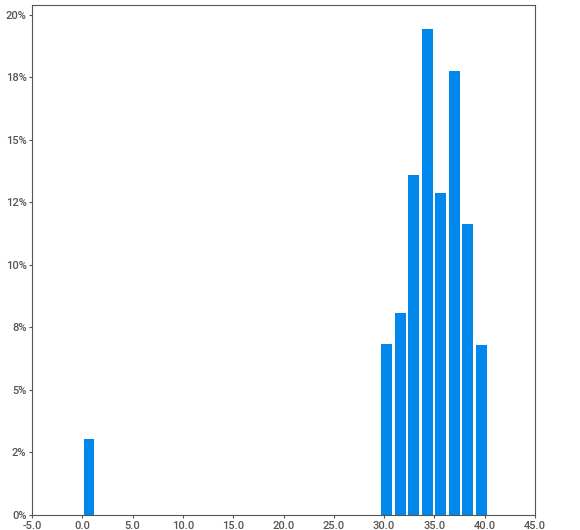
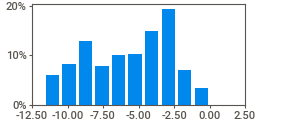
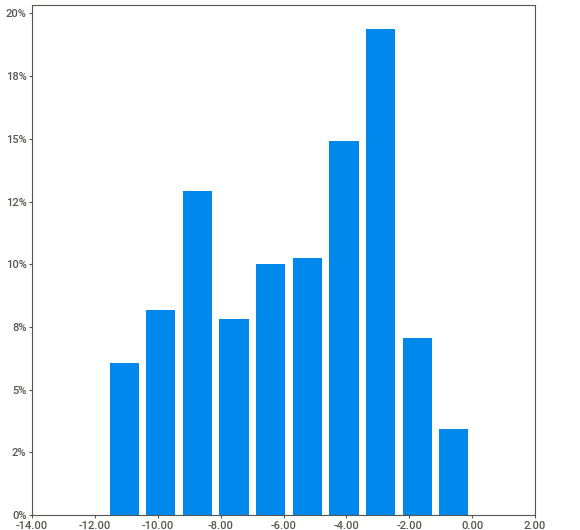
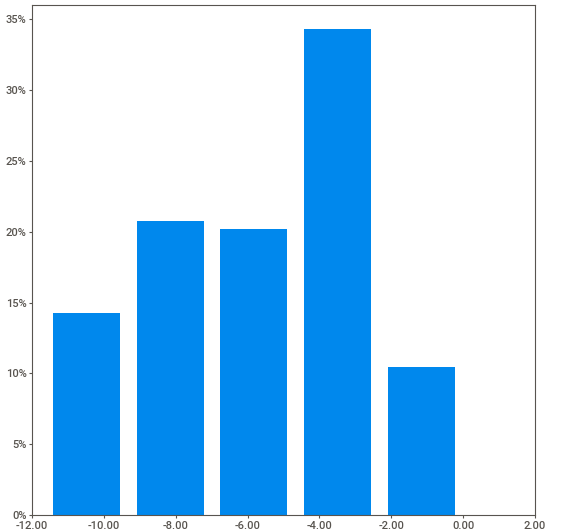
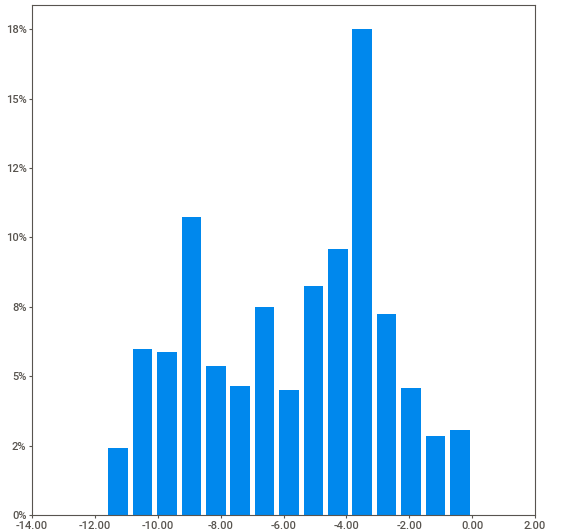
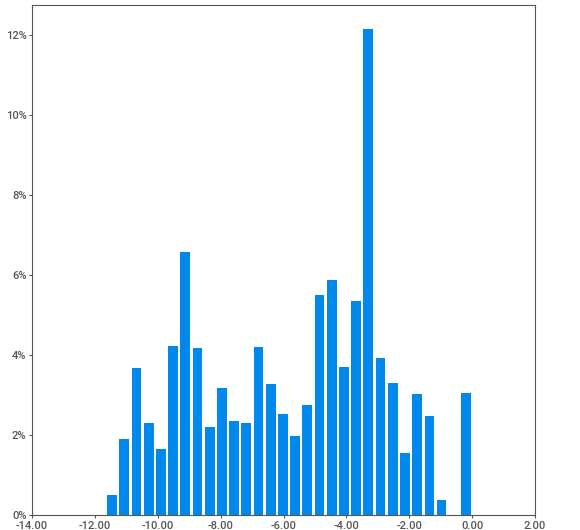
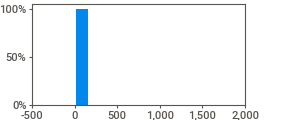
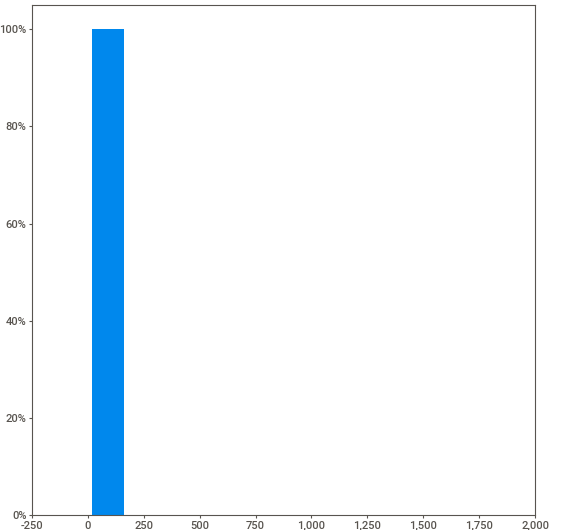
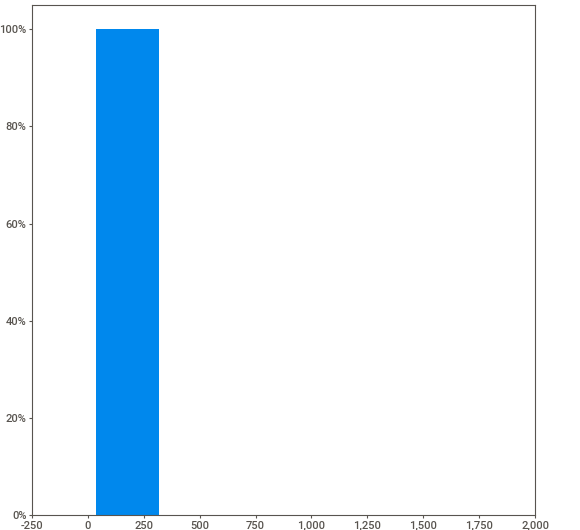
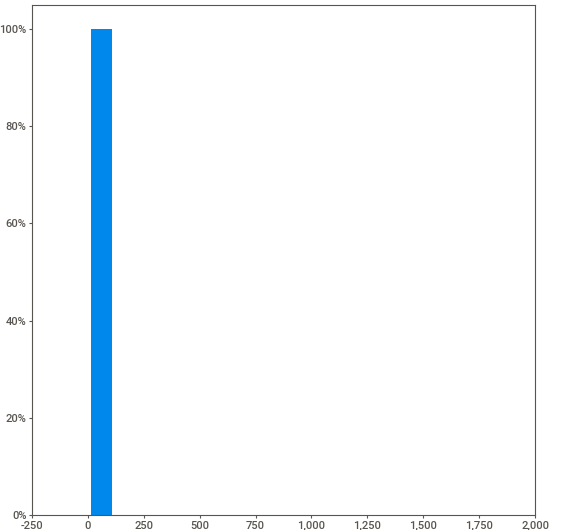
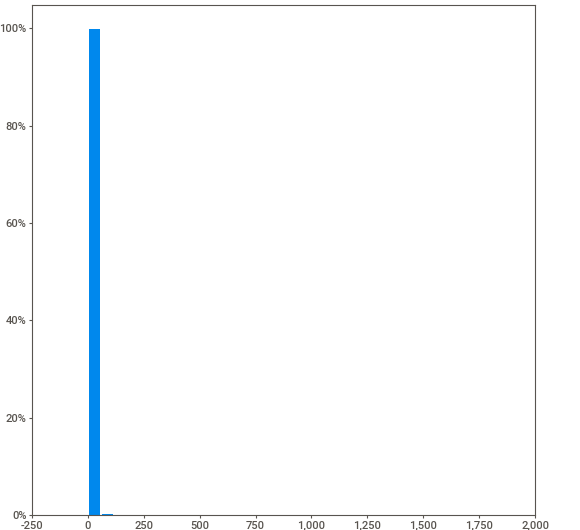
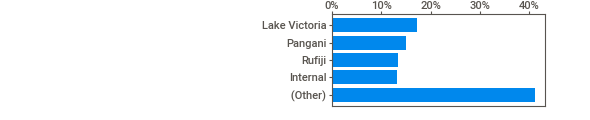
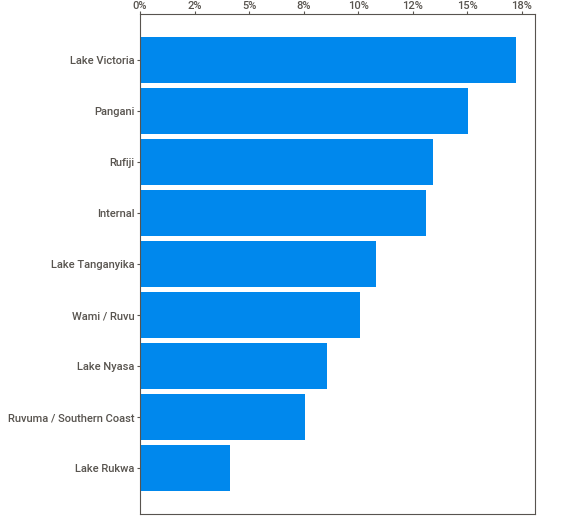
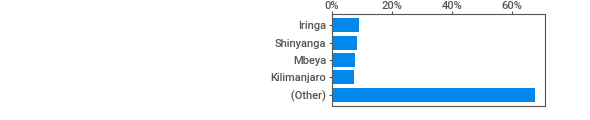
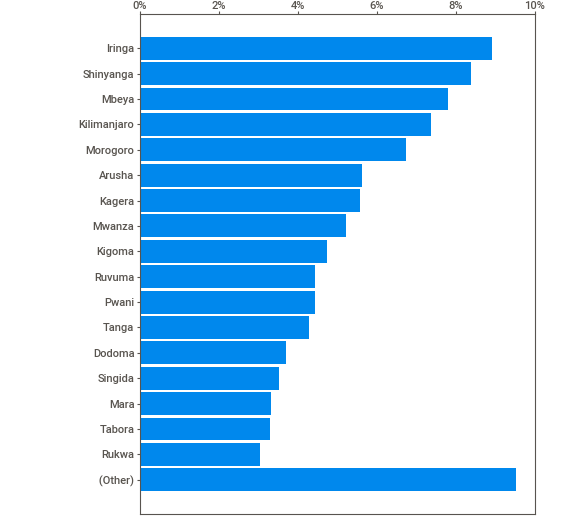
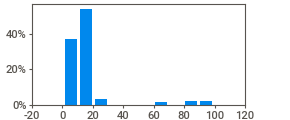
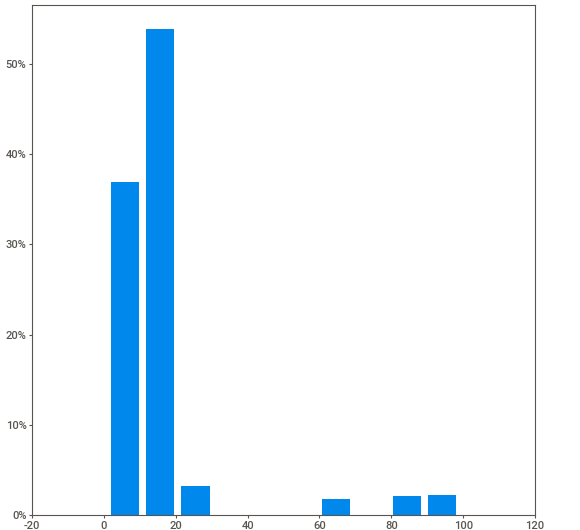
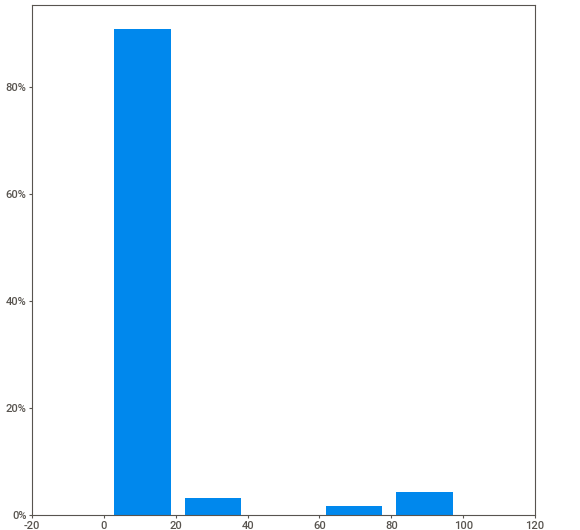
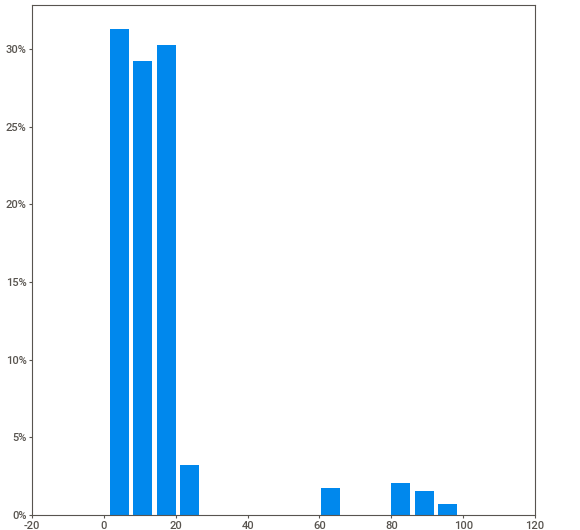
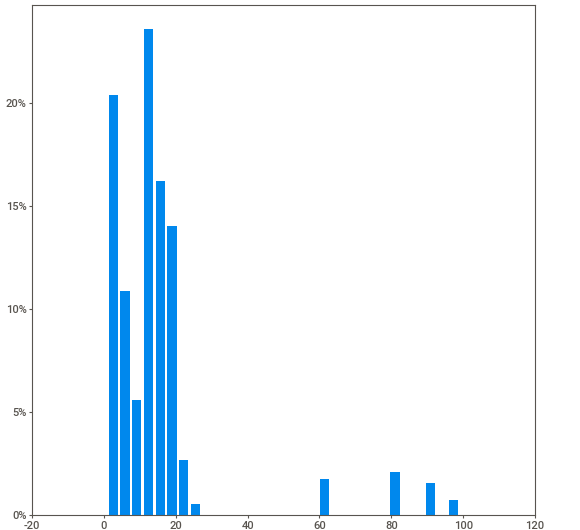
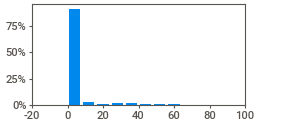
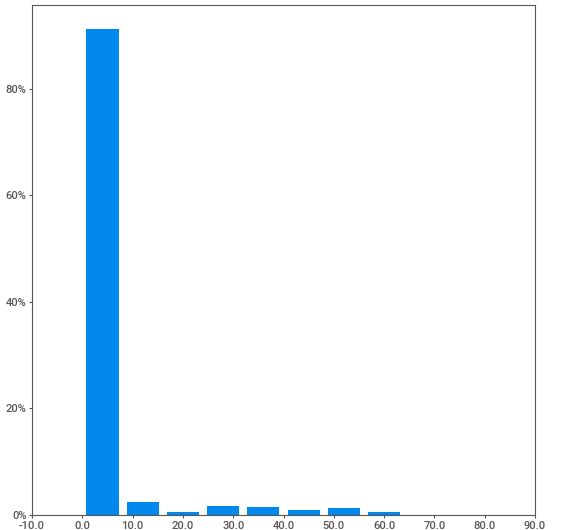
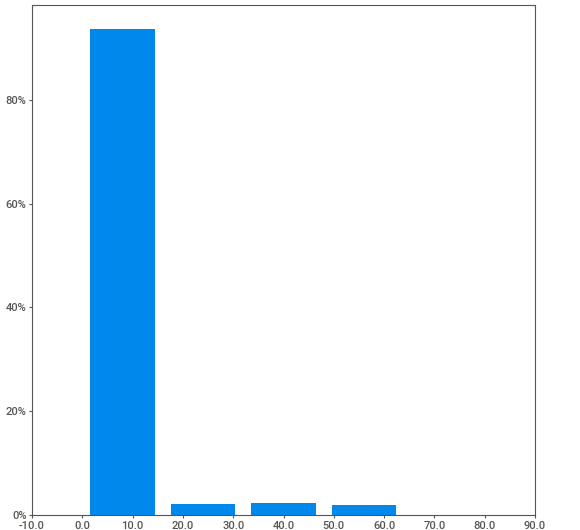
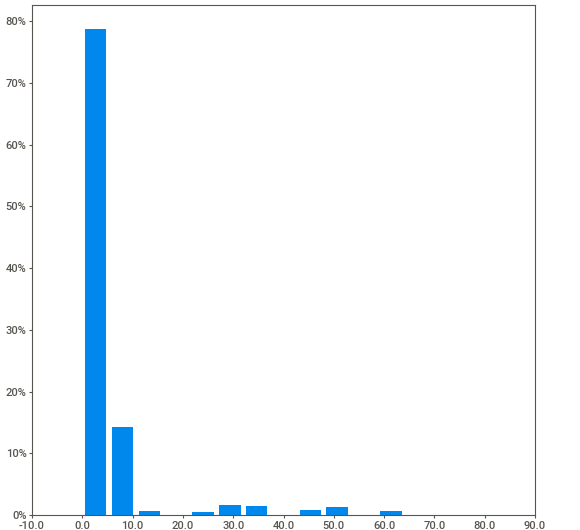
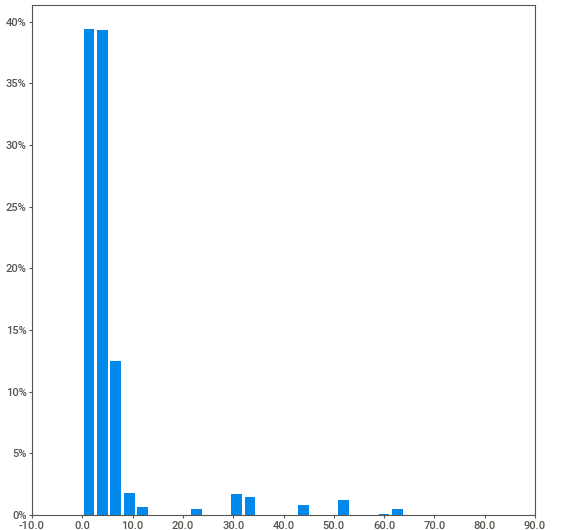
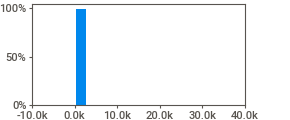
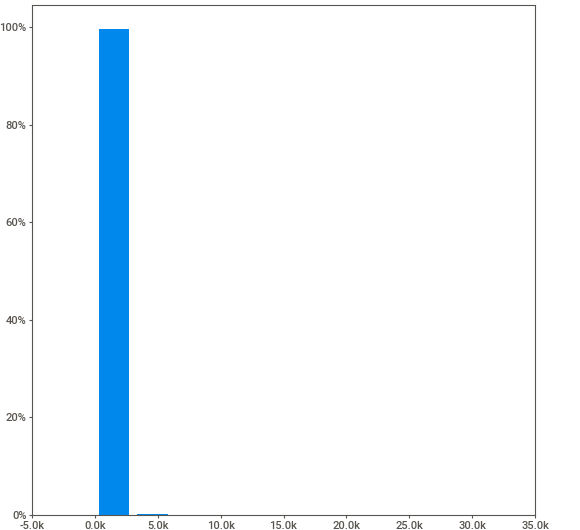
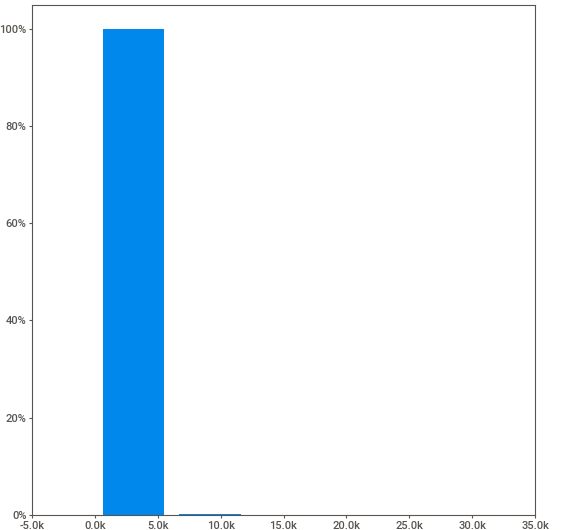
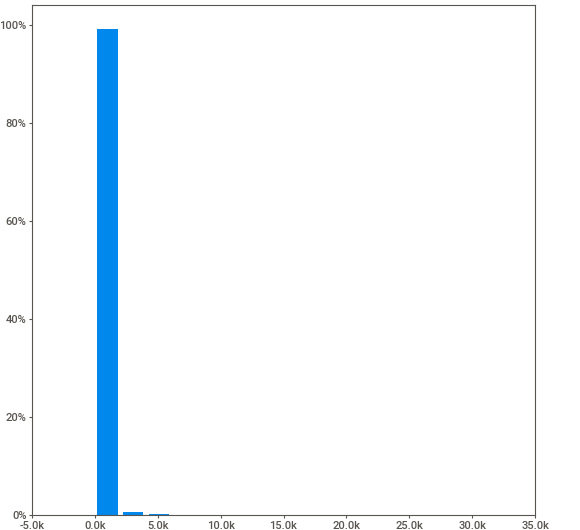
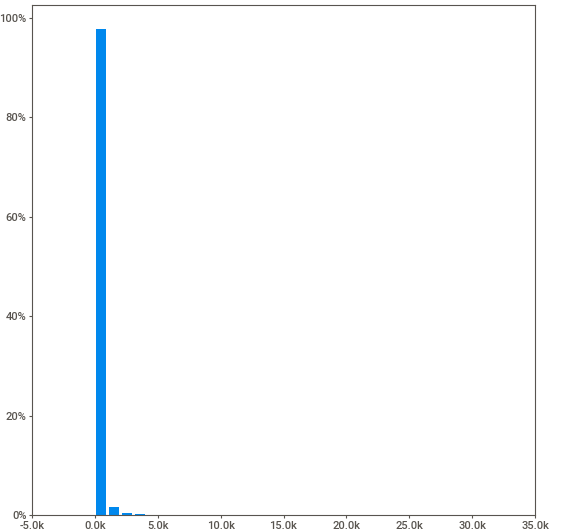
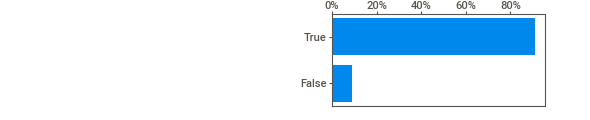
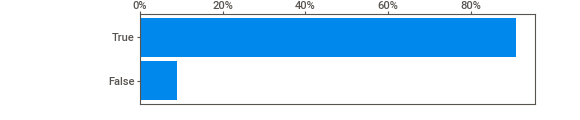
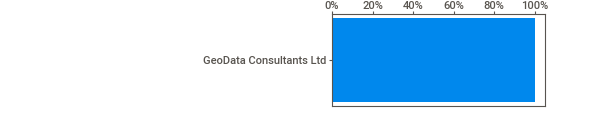
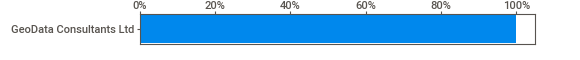
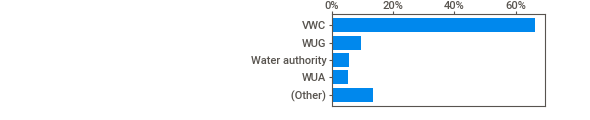
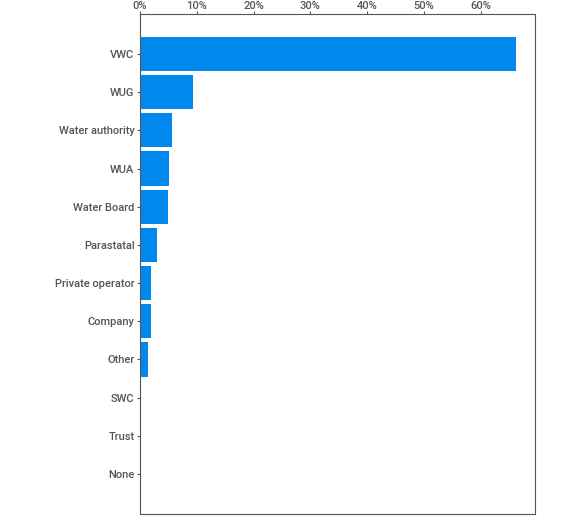
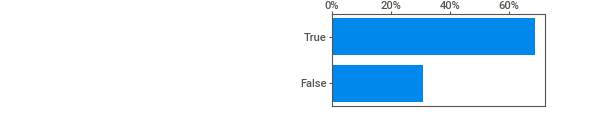
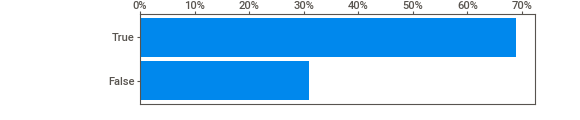
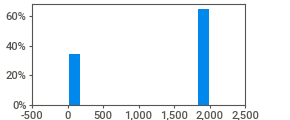
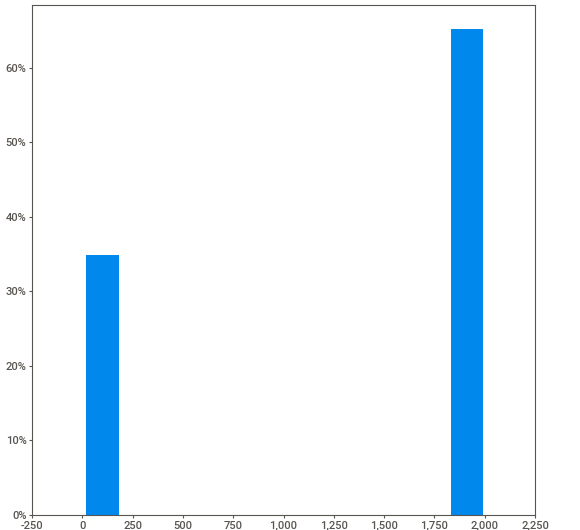
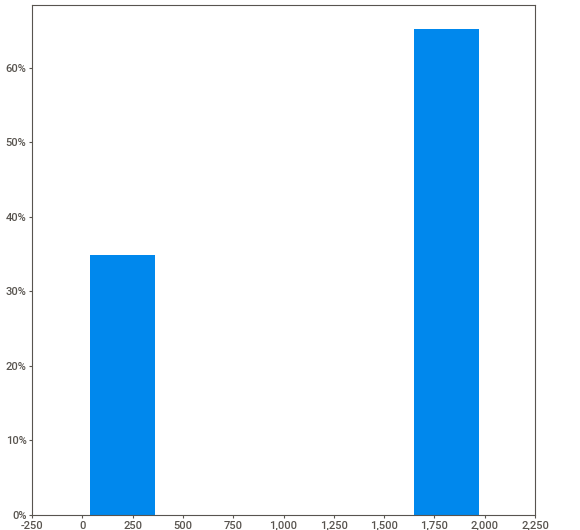
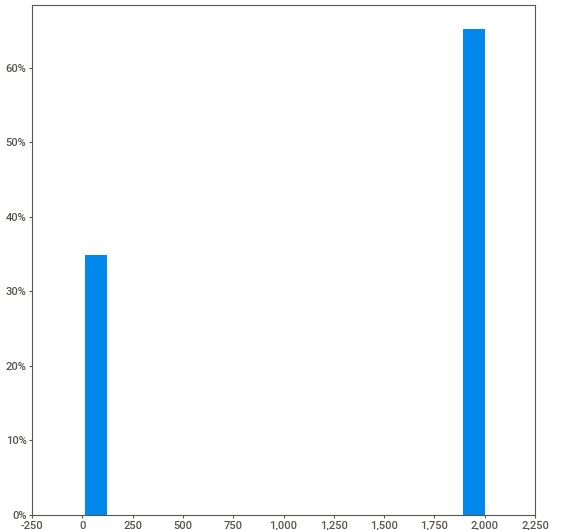
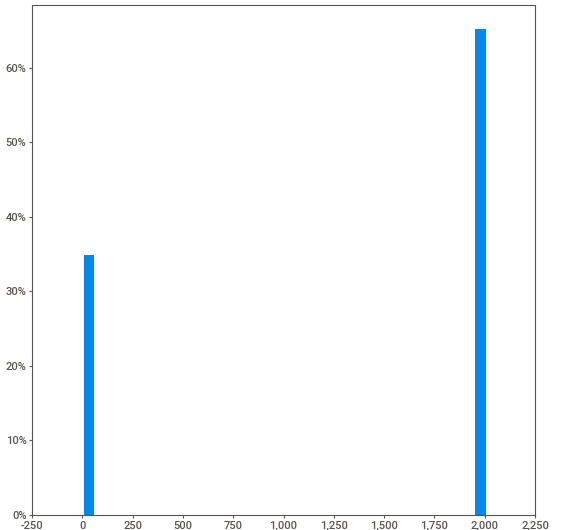
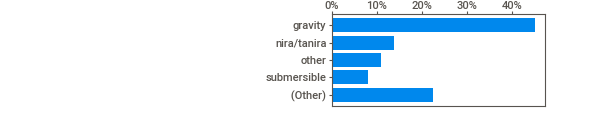
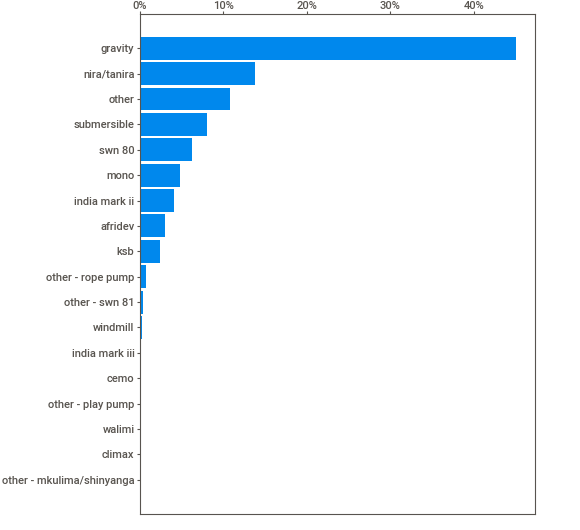
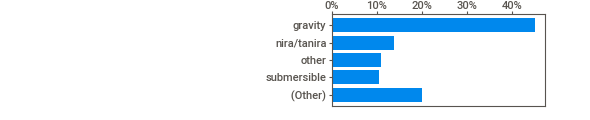
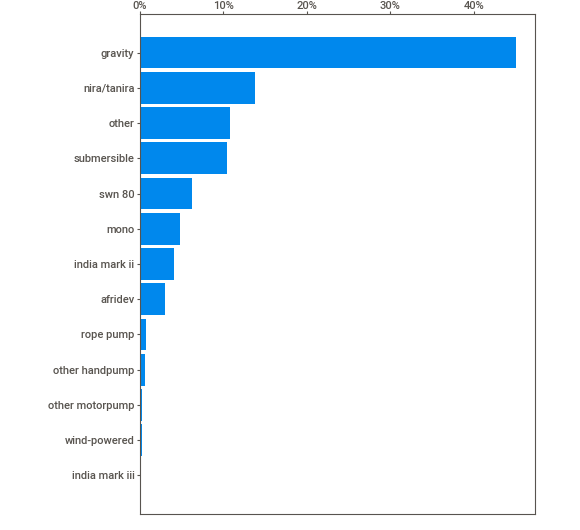
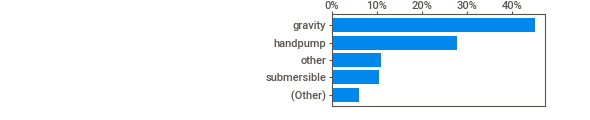
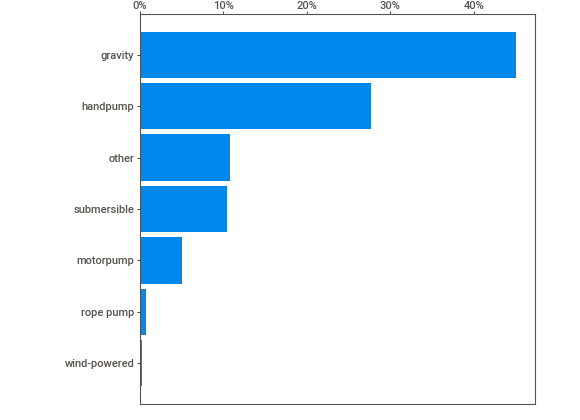
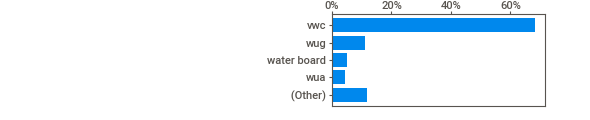
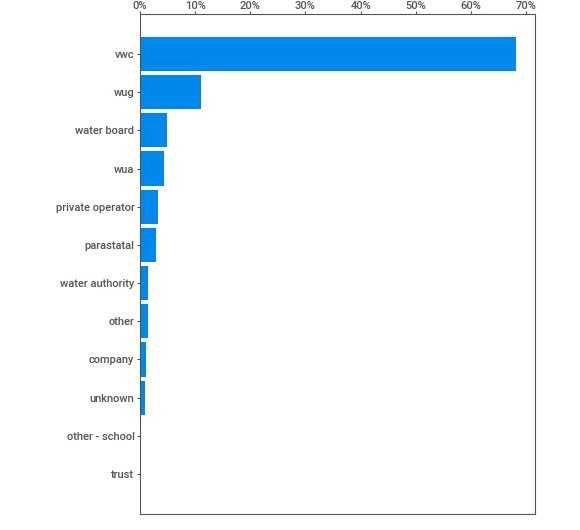
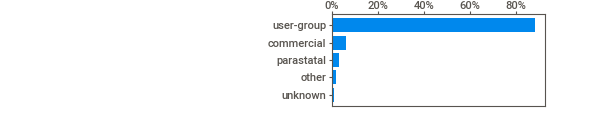
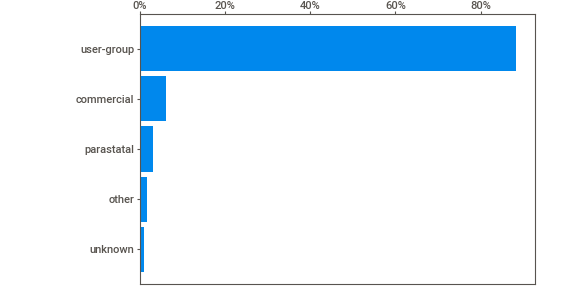
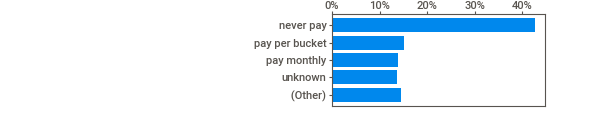
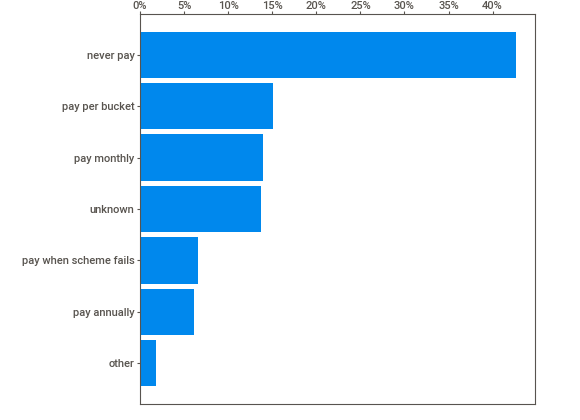
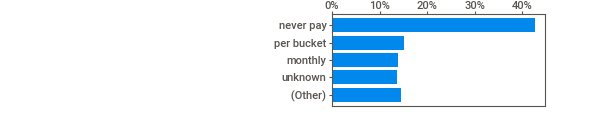
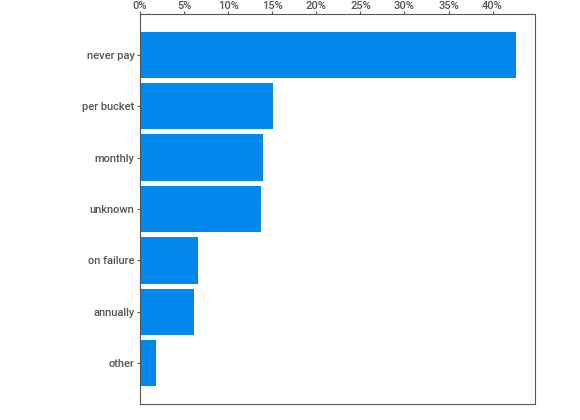
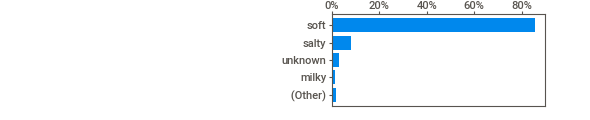
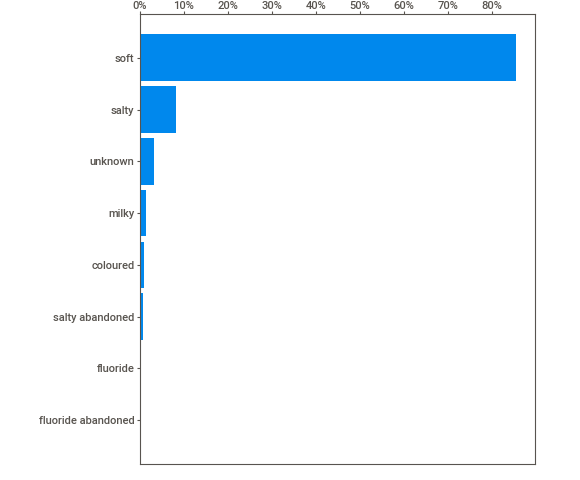
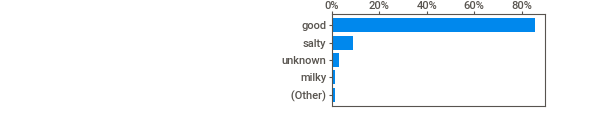
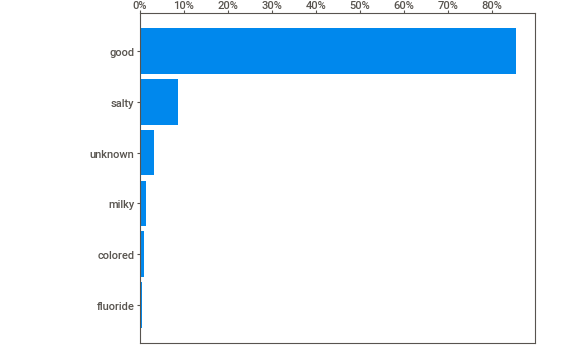
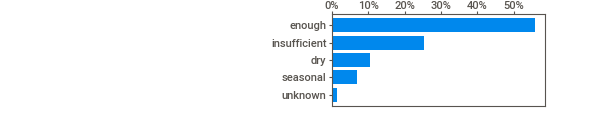
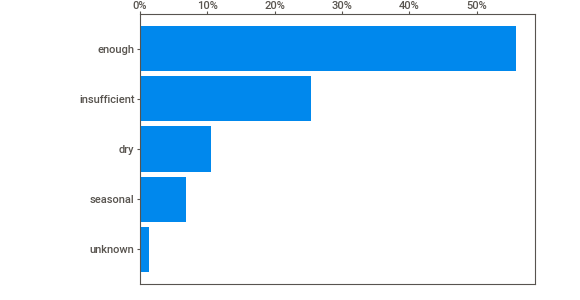
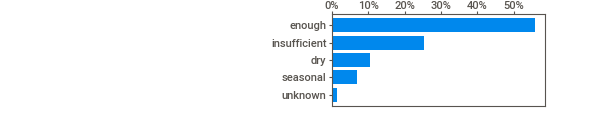
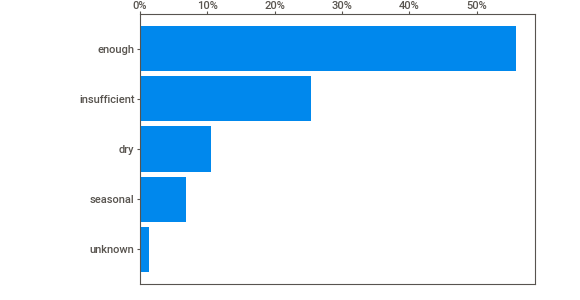
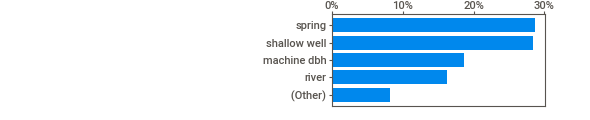
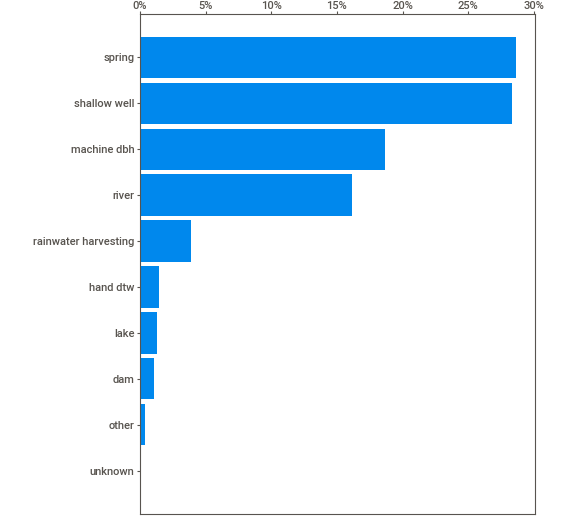
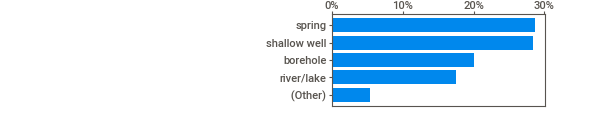
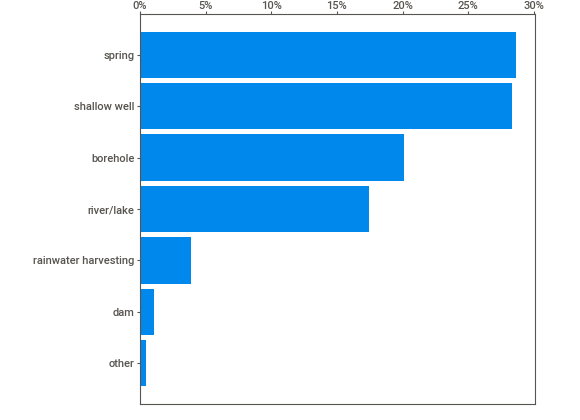
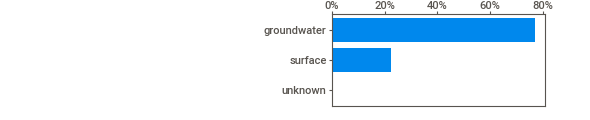
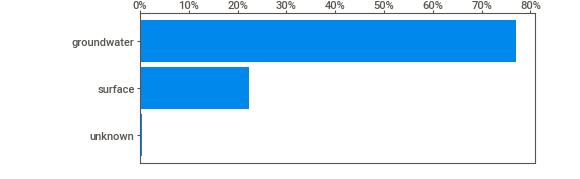
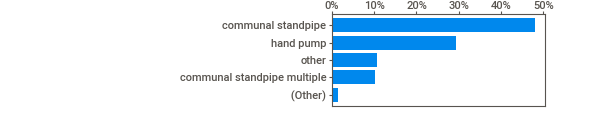
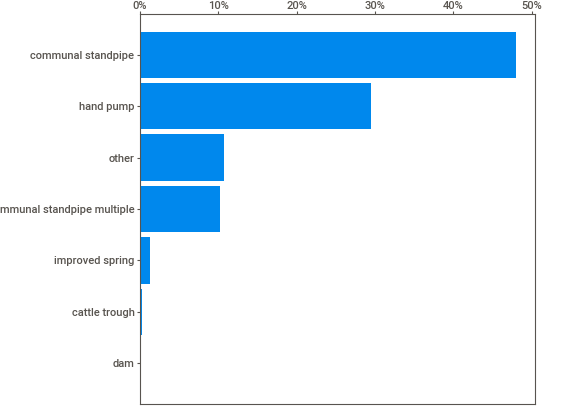
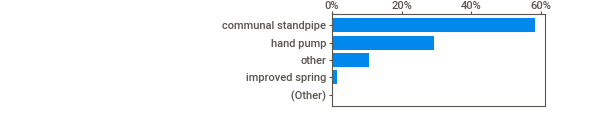
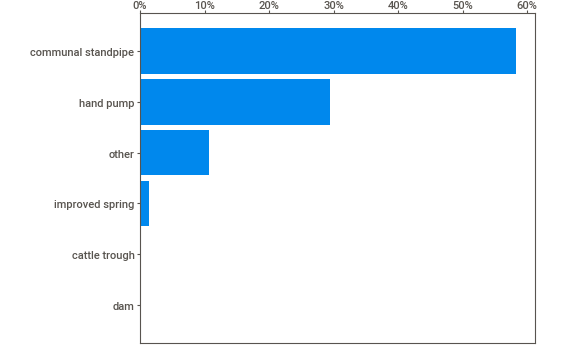
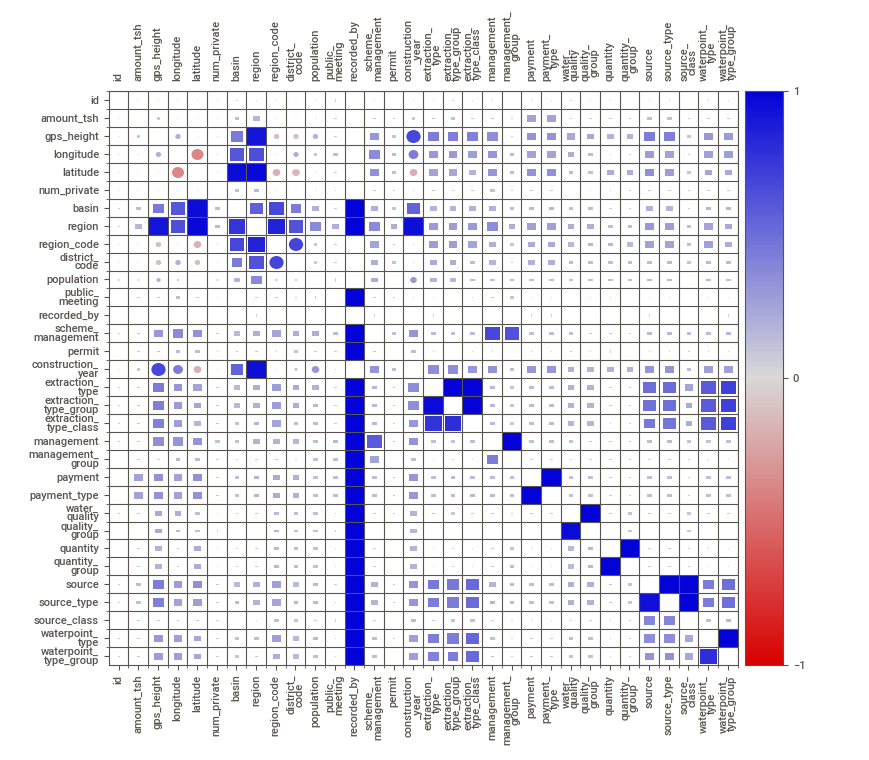
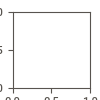

In [ ]:
my_report.show_notebook()

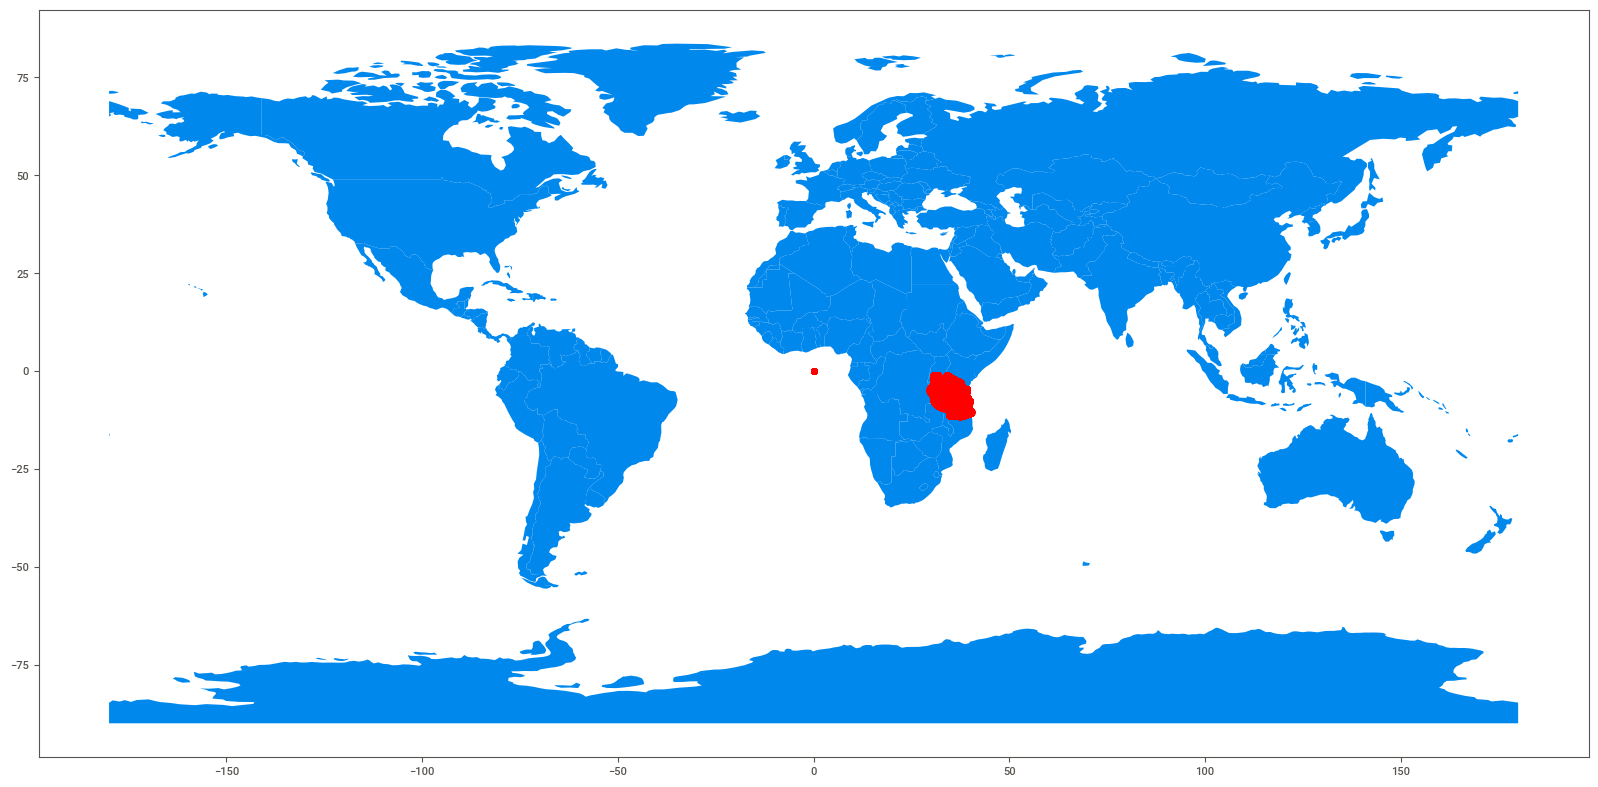

In [ ]:
#Plot the latitude and longitude
geometry = [Point(xy) for xy in zip(df_['longitude'], df_['latitude'])]
gdf = GeoDataFrame(df_, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 20)), marker='o', color='red', markersize=15);

> Seems one of the longitude is not at the right point -> This needs to be fixed -> Would use imputations

## Data Cleanup/Pre-Processing

In [45]:
#Creating a copy of the dataset
df_w = df_.copy()

In [46]:
#Impute the NANs created above with values according to the Imputation/KNN

df_w.loc[df_w['longitude'] == 0, 'longitude'] = np.nan
df_w[df_w['longitude'] == 0]
imputer = KNNImputer(n_neighbors=3, weights="uniform")
df_w['longitude'] = imputer.fit_transform(df_w[['longitude']])

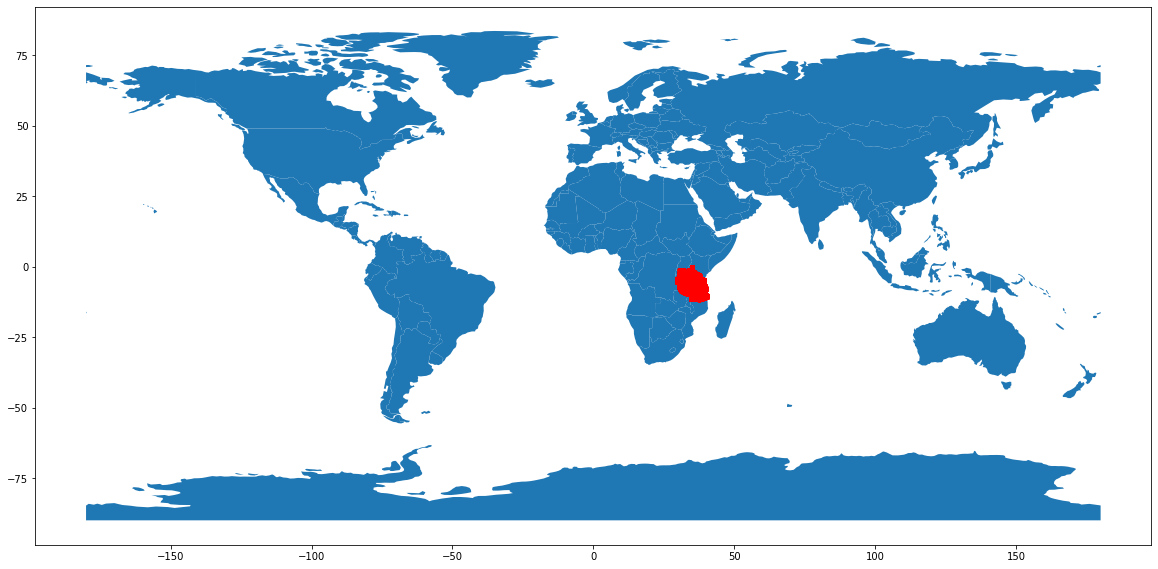

In [ ]:
#Plot the latitude and longitude to check the imputations
geometry = [Point(xy) for xy in zip(df_w['longitude'], df_w['latitude'])]
gdf = GeoDataFrame(df_w, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 20)), marker='o', color='red', markersize=15);

In [47]:
#Remove the unnecessary columns

df_w.drop(columns=['wpt_name','num_private','subvillage','region_code','scheme_name','recorded_by'], inplace= True)

In [ ]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55765 non-null  object        
 4   gps_height             59400 non-null  int64         
 5   installer              55745 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   basin                  59400 non-null  object        
 9   region                 59400 non-null  object        
 10  district_code          59400 non-null  int64         
 11  lga                    59400 non-null  object        
 12  ward                   59400 non-null  object        
 13  p

In [48]:
#Add the target variable to the main dataframe and encode it with the values 0, 1 and 2

df_w['status_group'] = pd.Series(df_lab_['status_group']).map({"functional":0,"non functional":1,"functional needs repair":2})

Exploration using Sweetviz - After Cleaining

                                             |          | [  0%]   00:00 -> (? left)


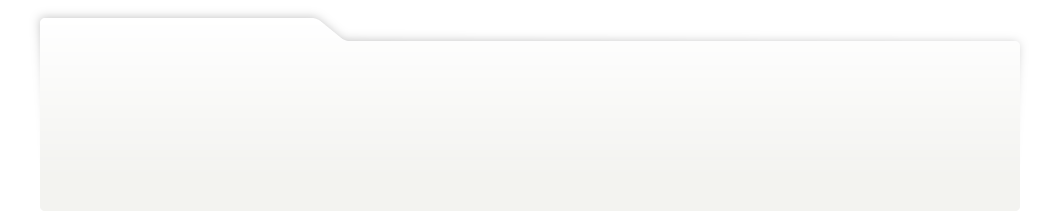
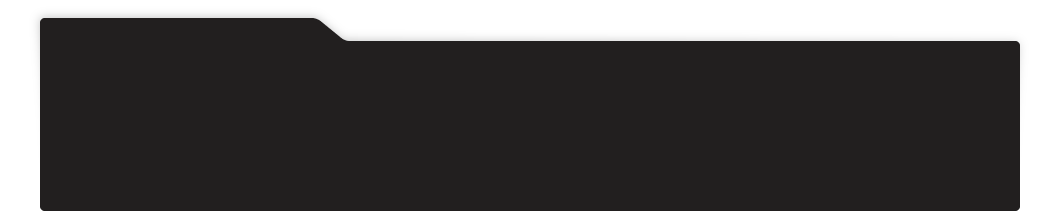
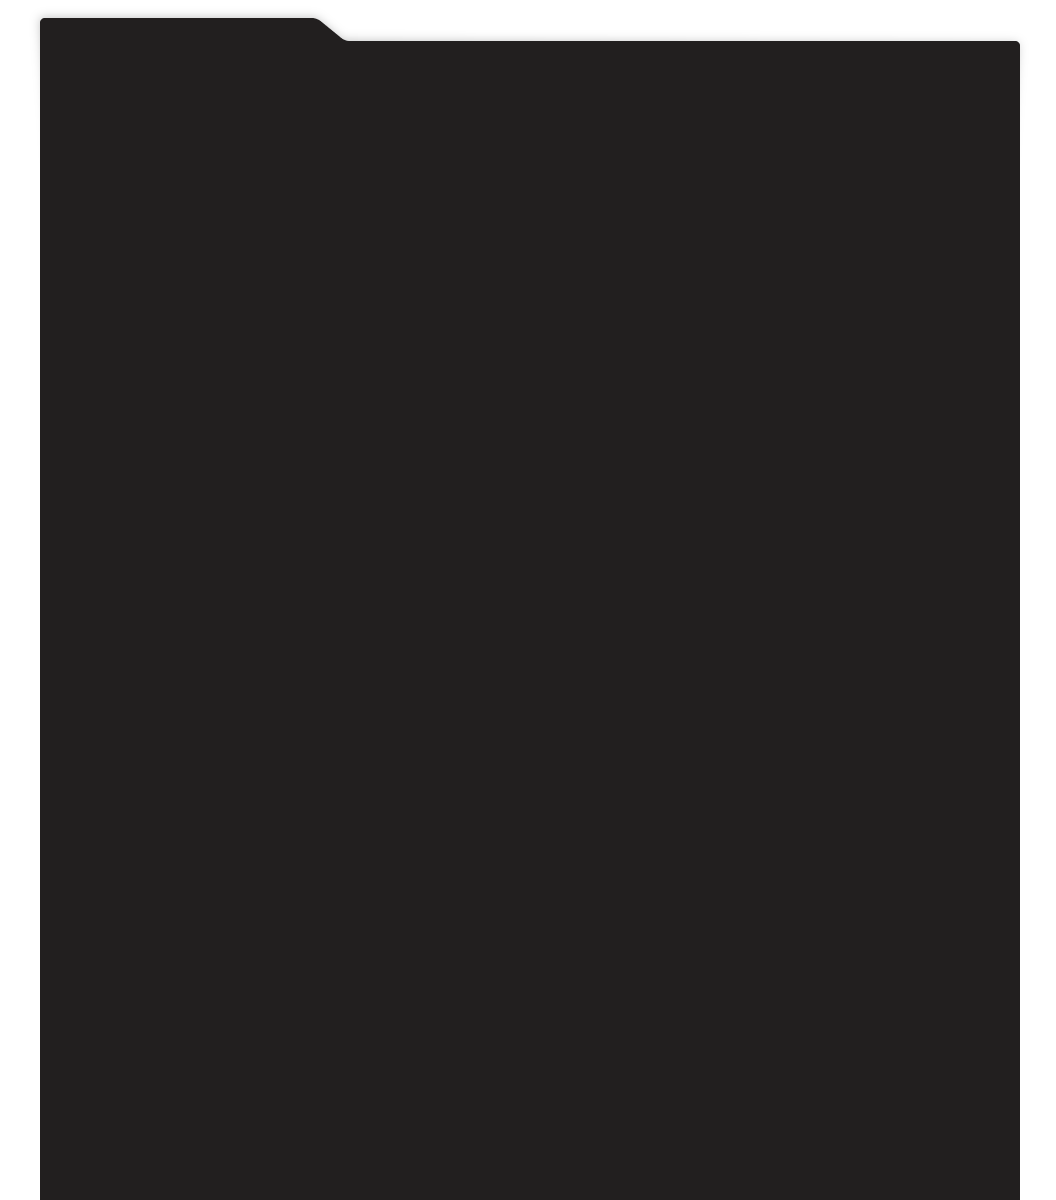
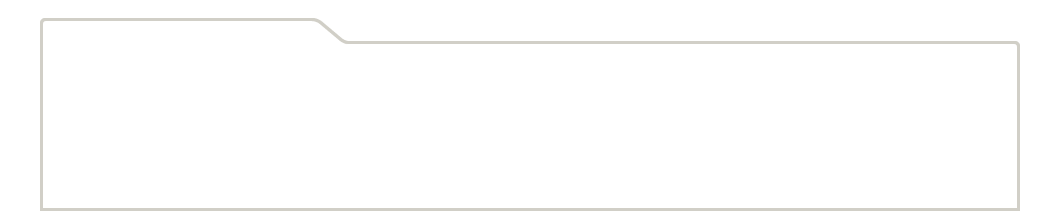
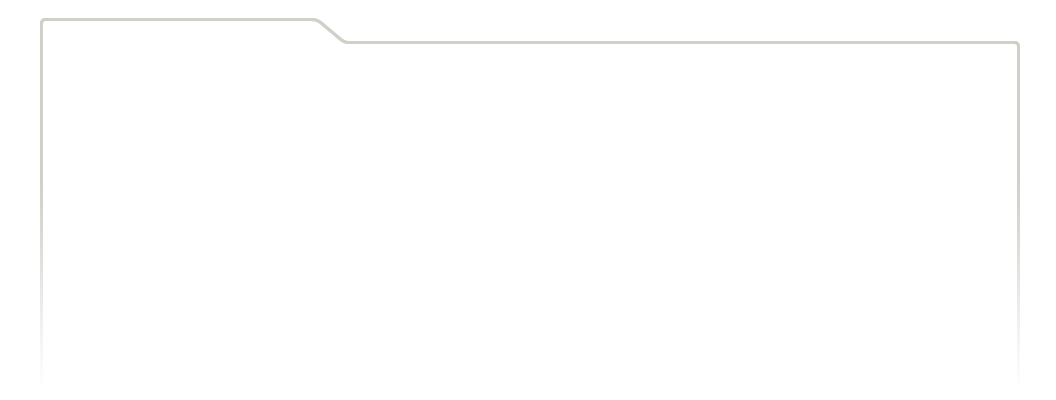
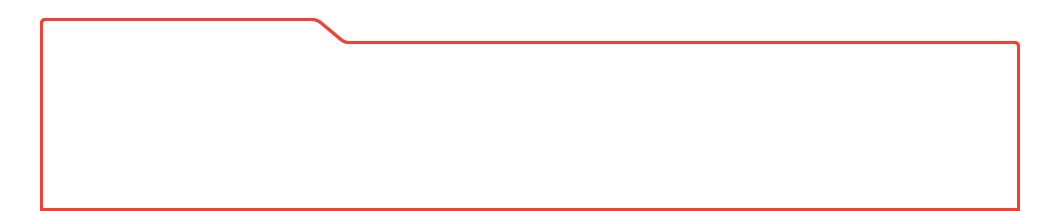
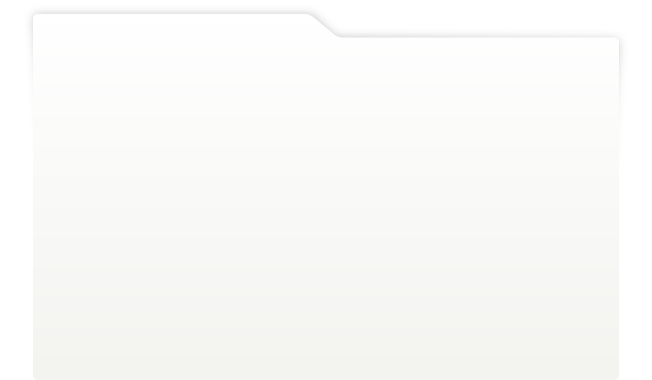
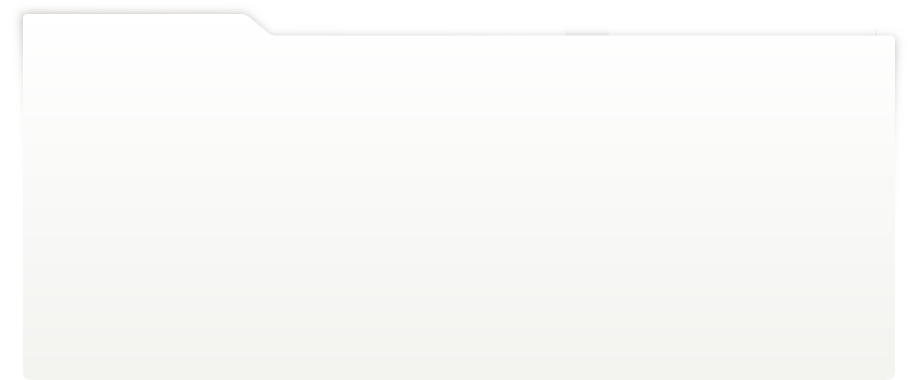
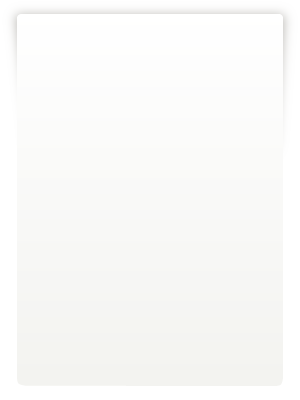
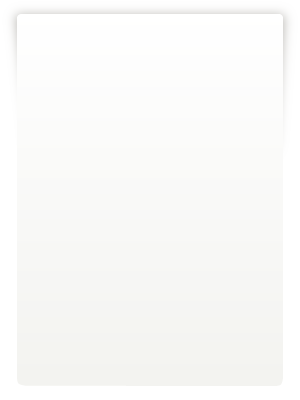
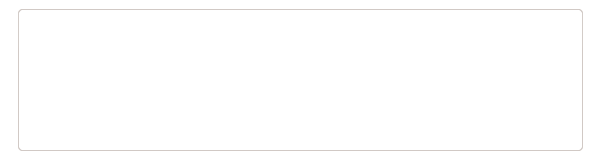
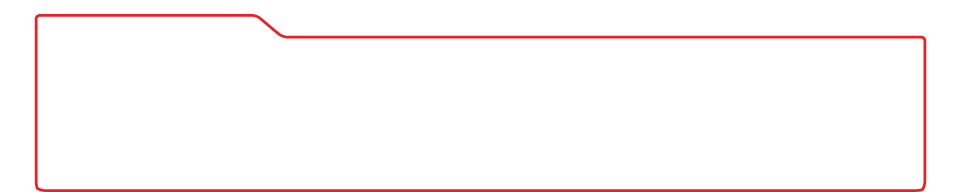
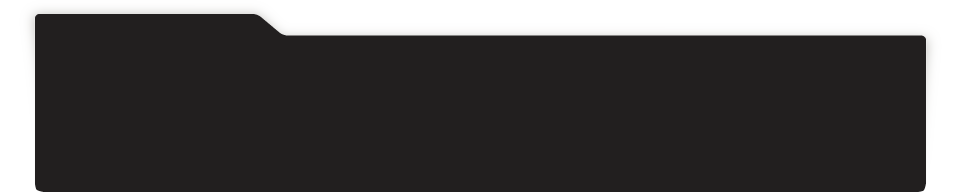
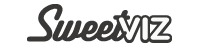
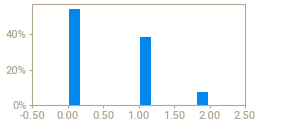
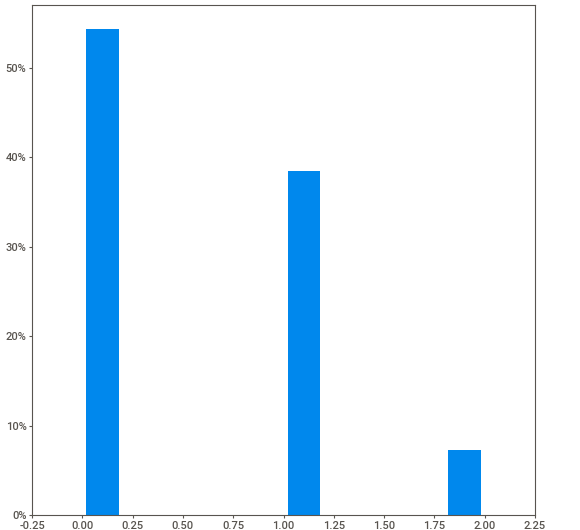
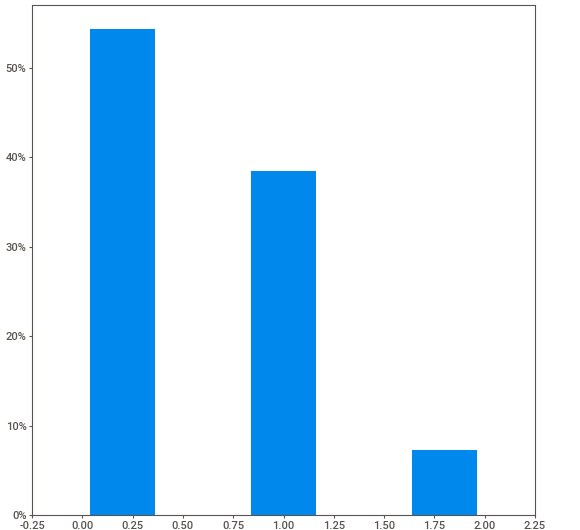
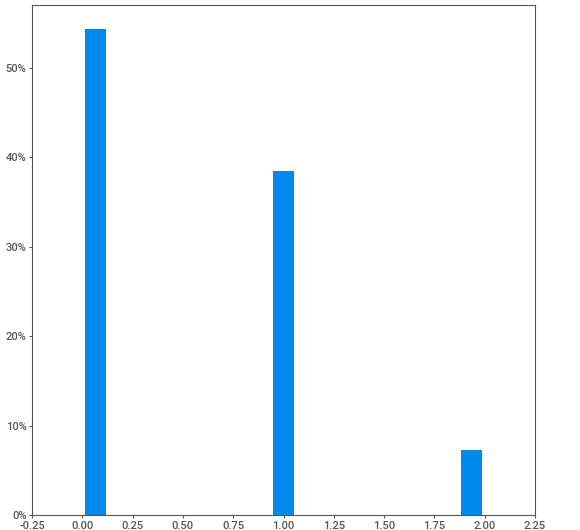
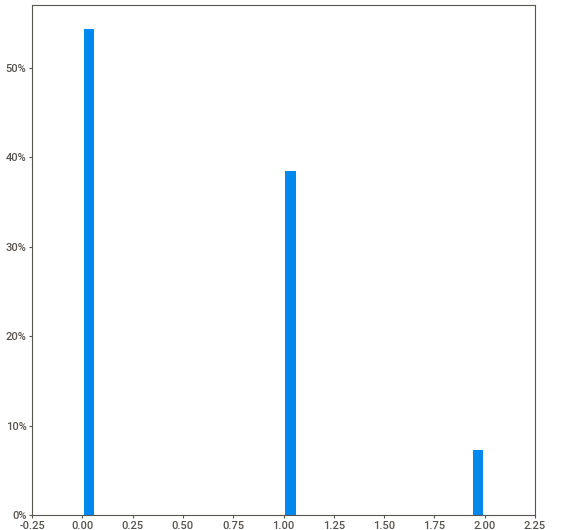
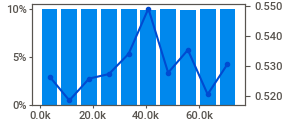
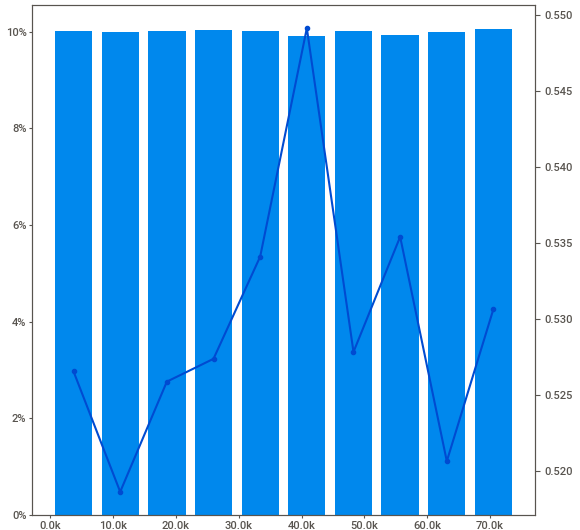
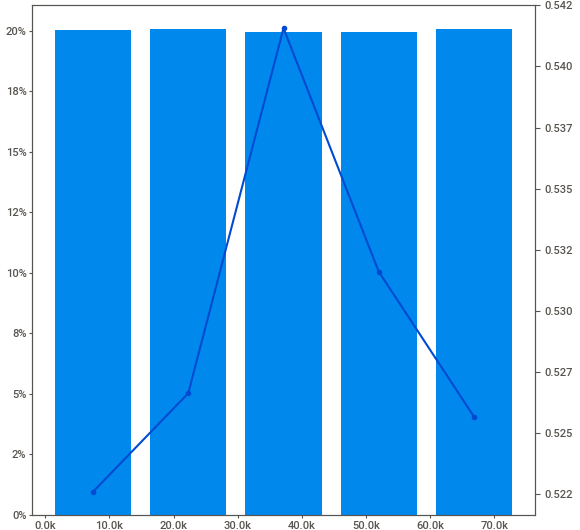
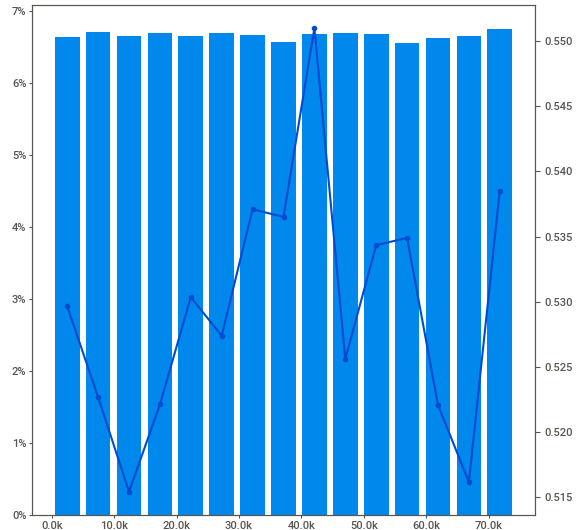
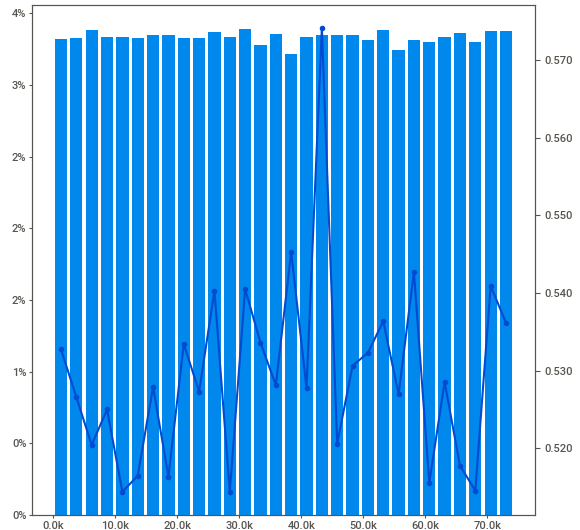
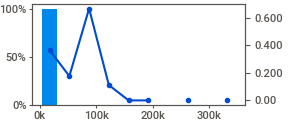
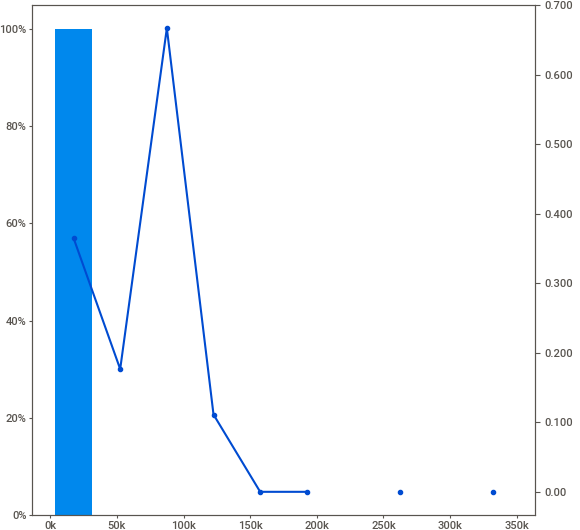
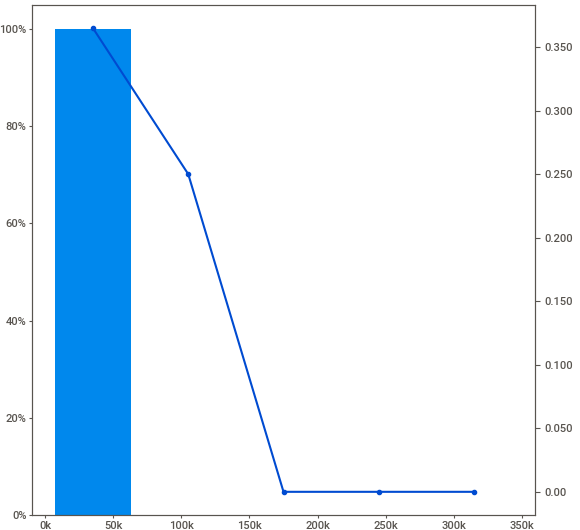
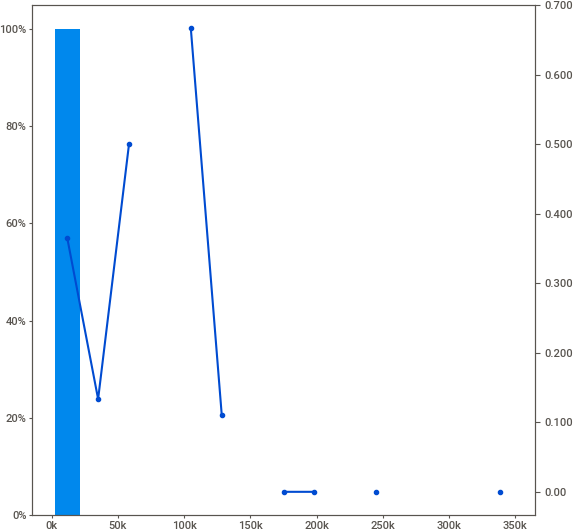
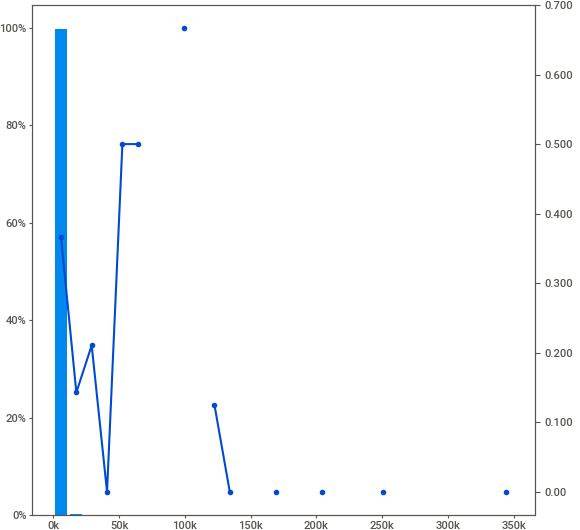
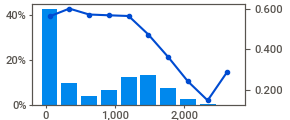
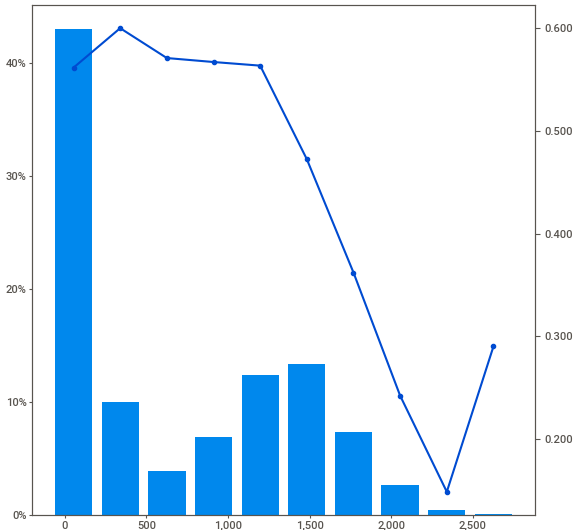
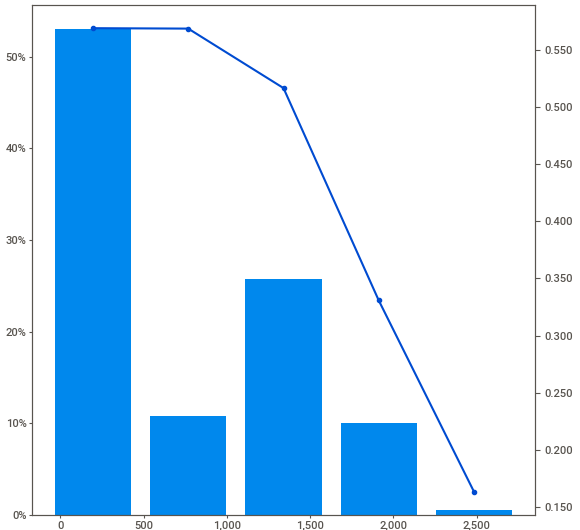
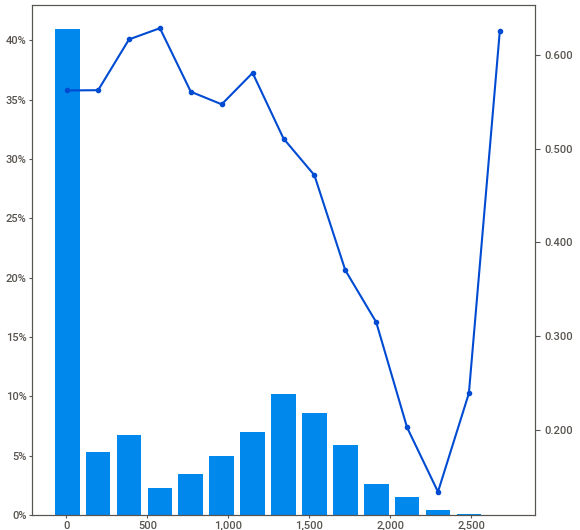
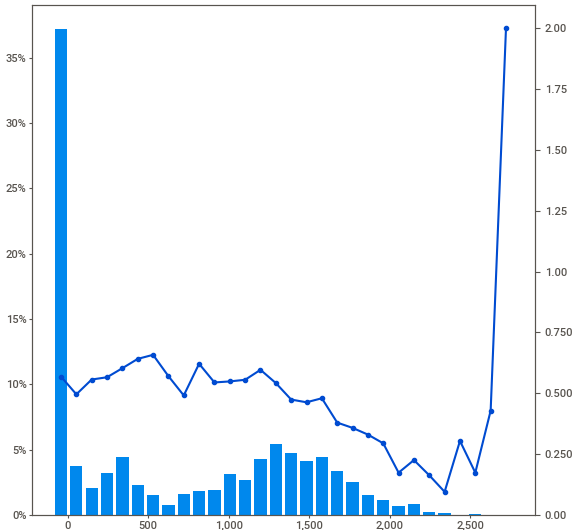
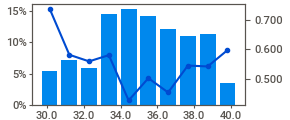
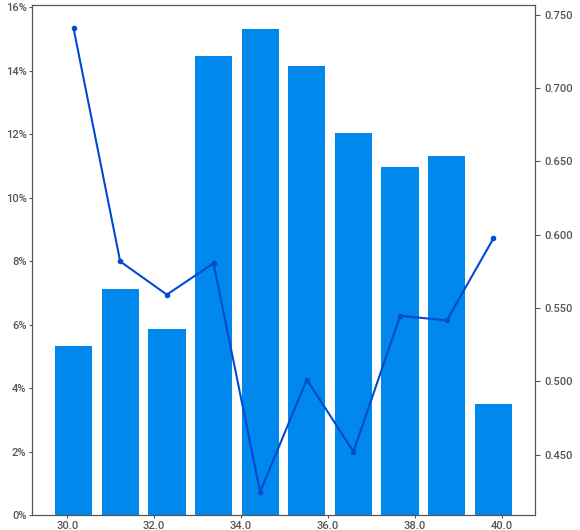
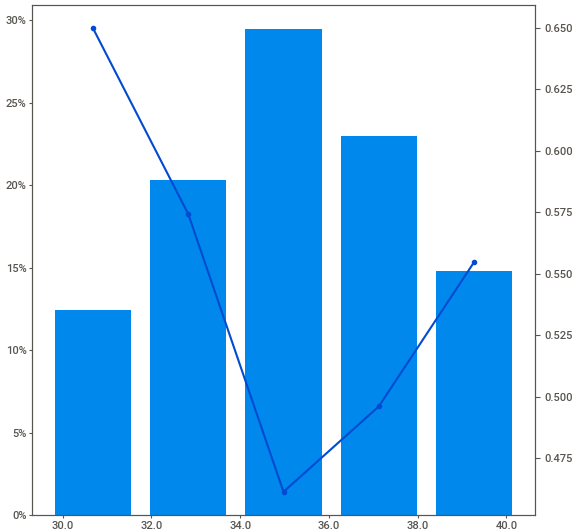
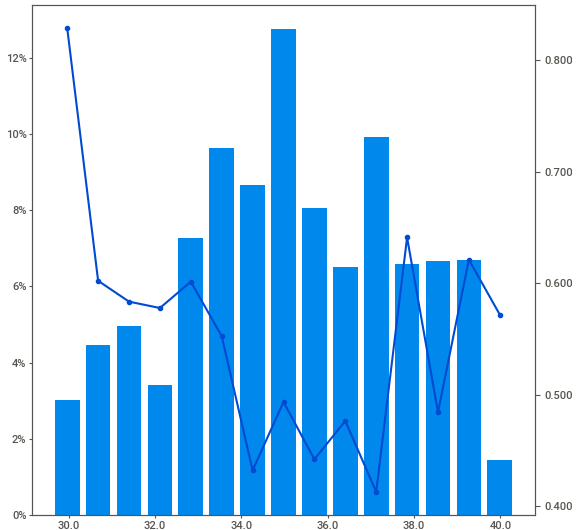
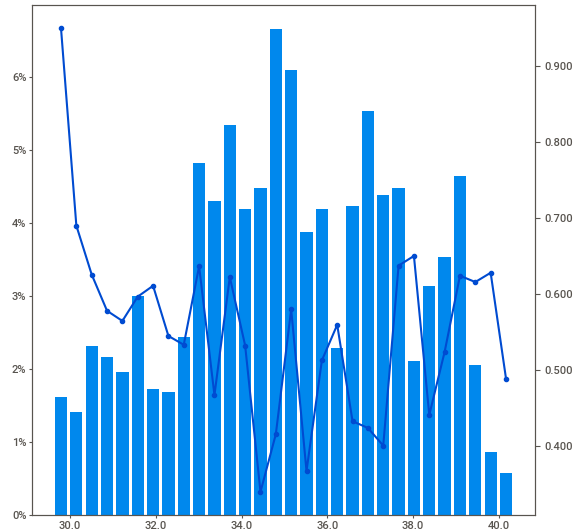
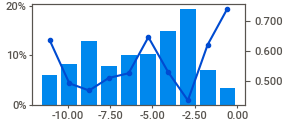
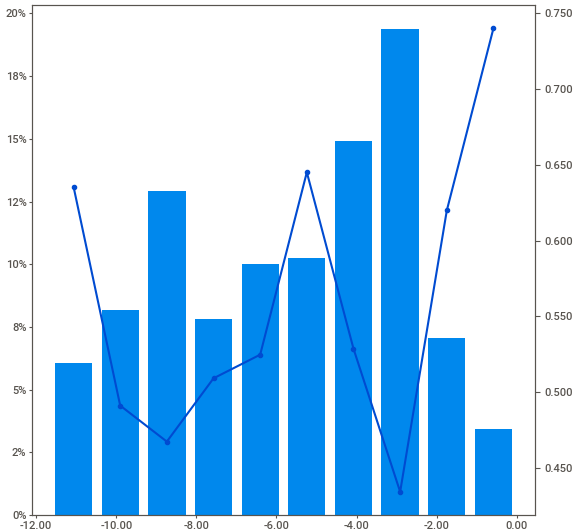
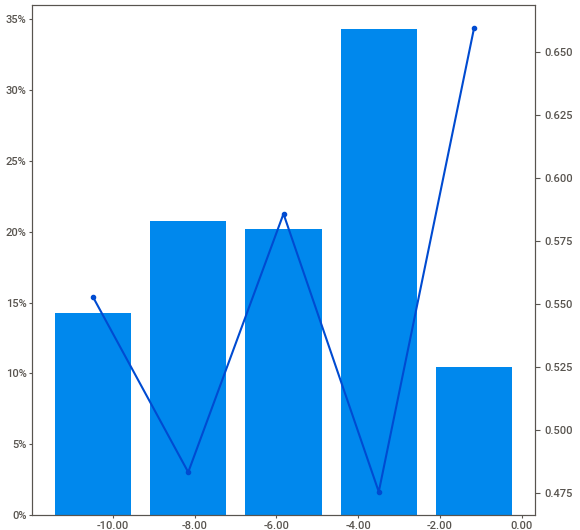
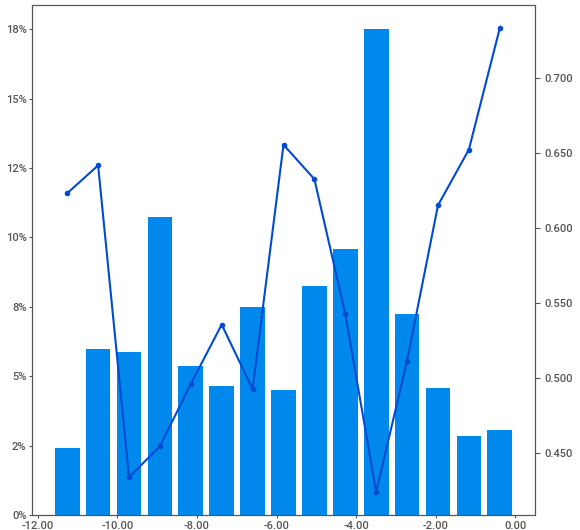
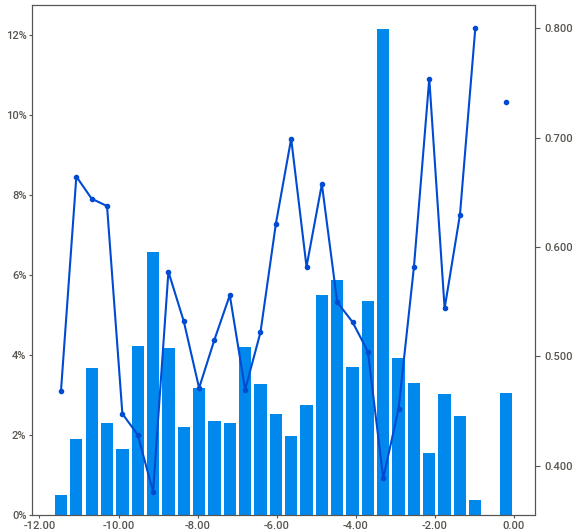
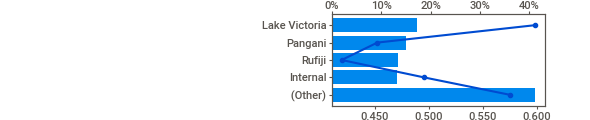
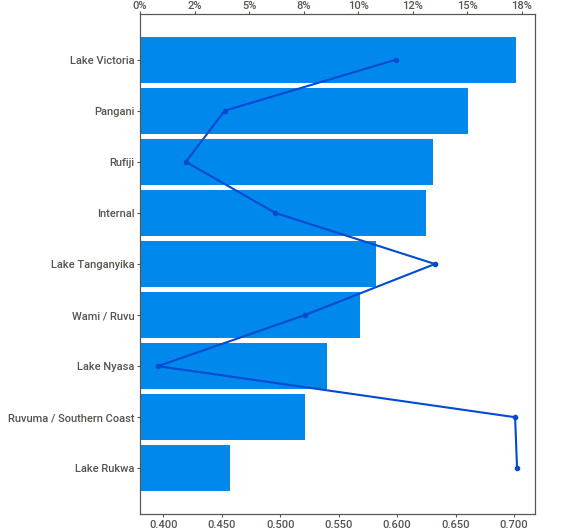
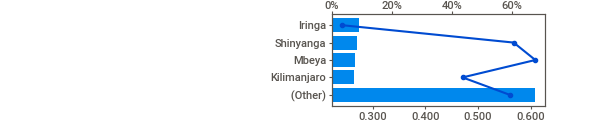
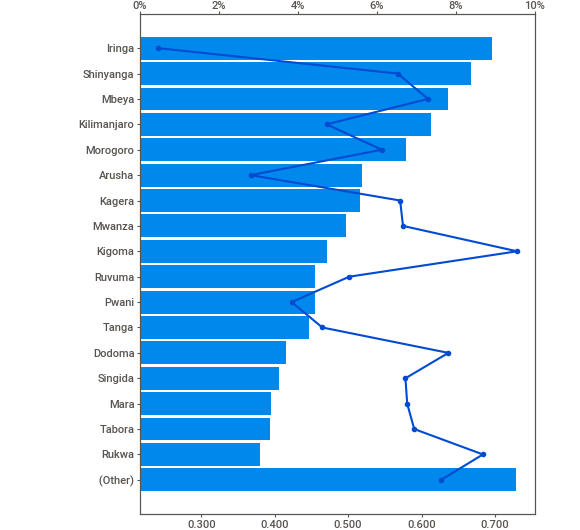
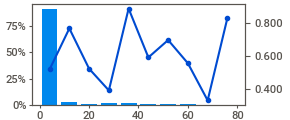
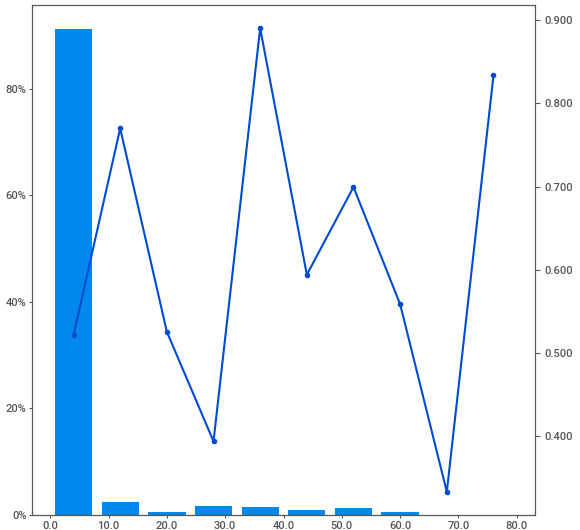
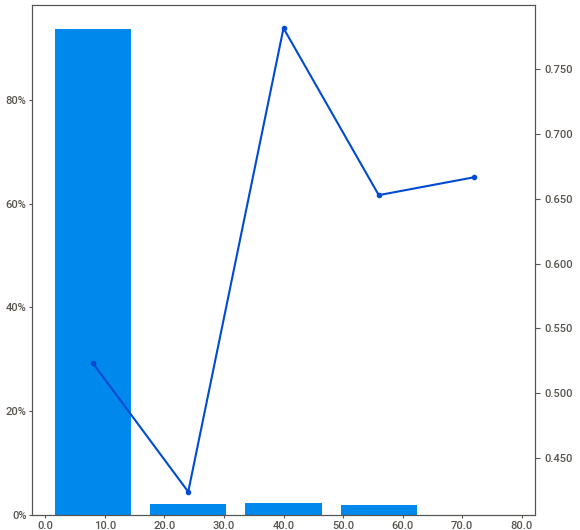
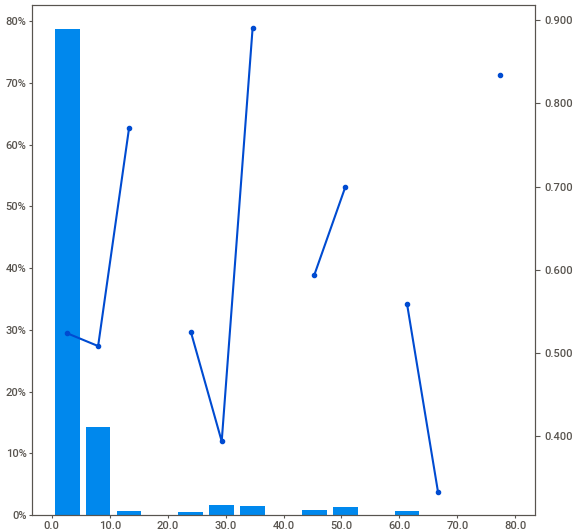
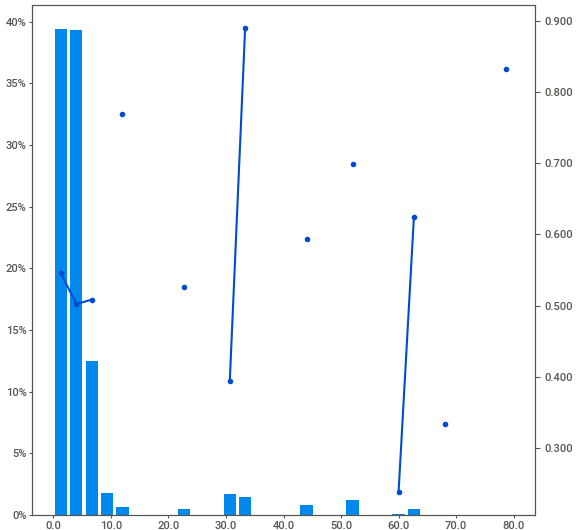
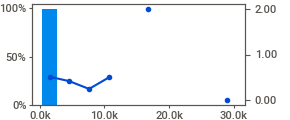
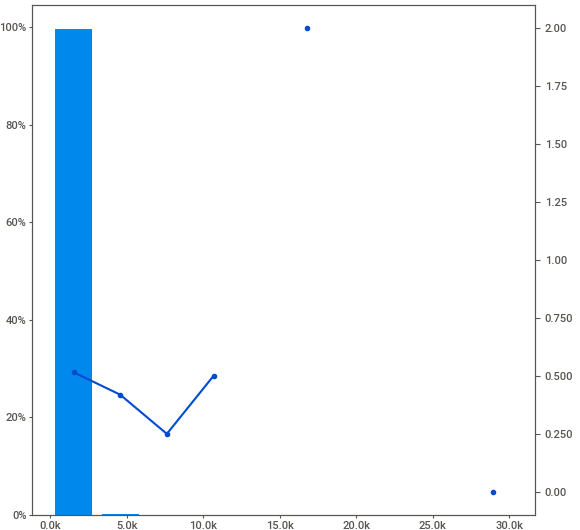
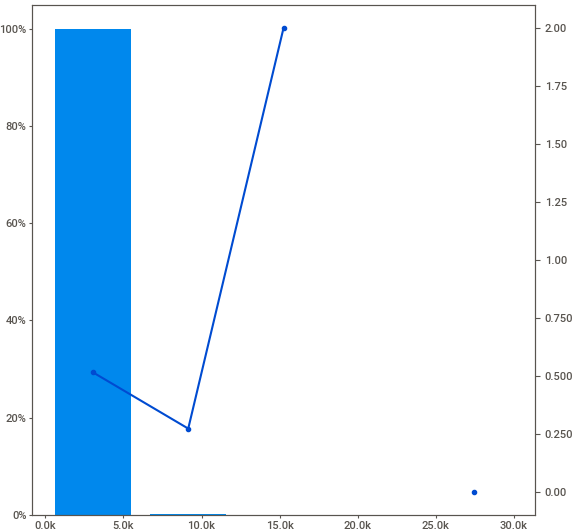
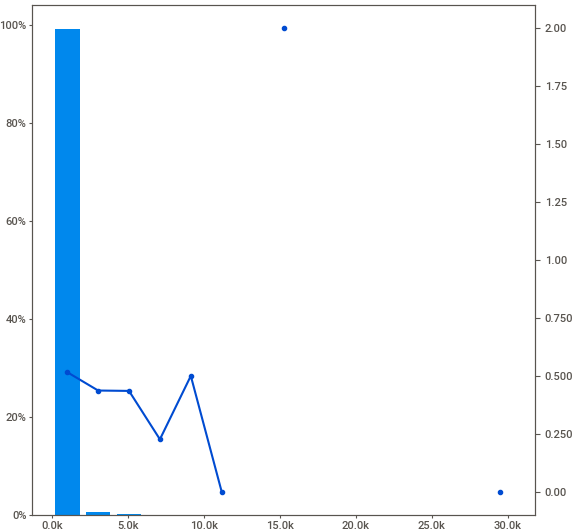
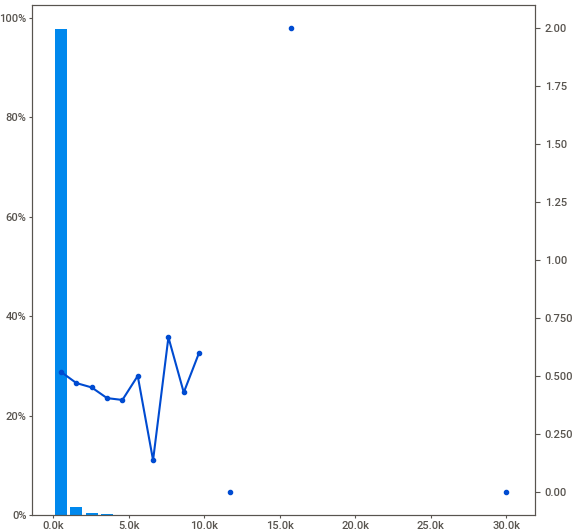
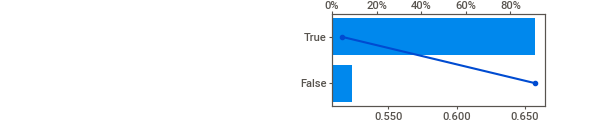
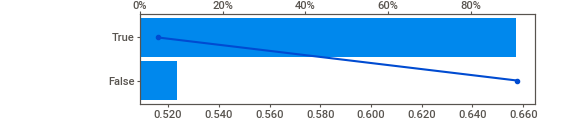
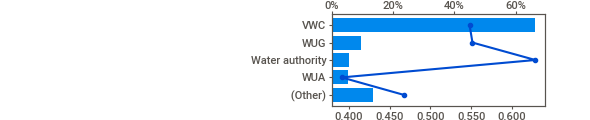
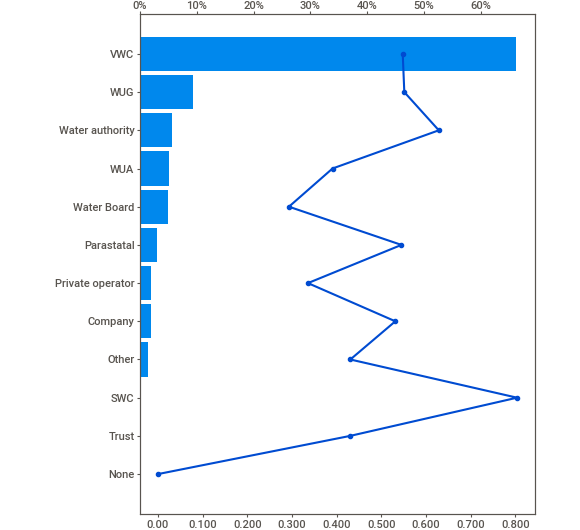
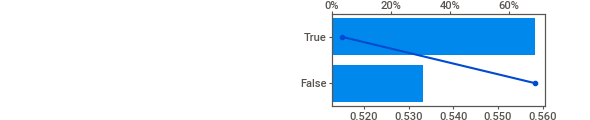
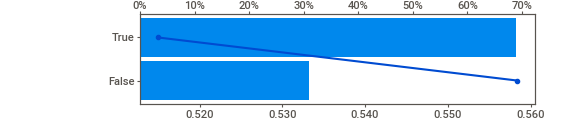
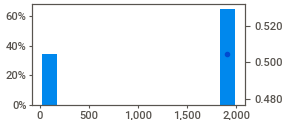
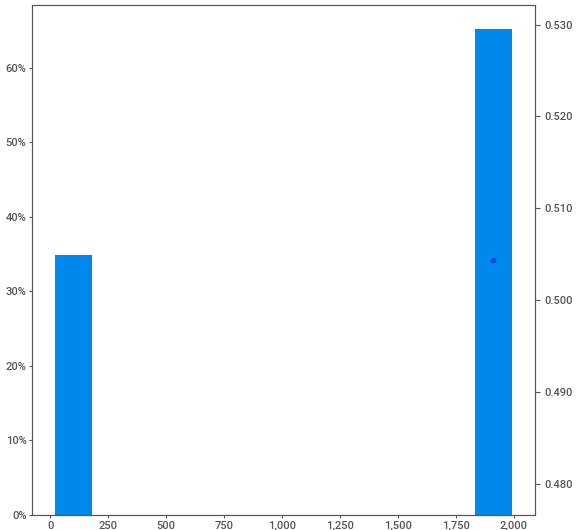
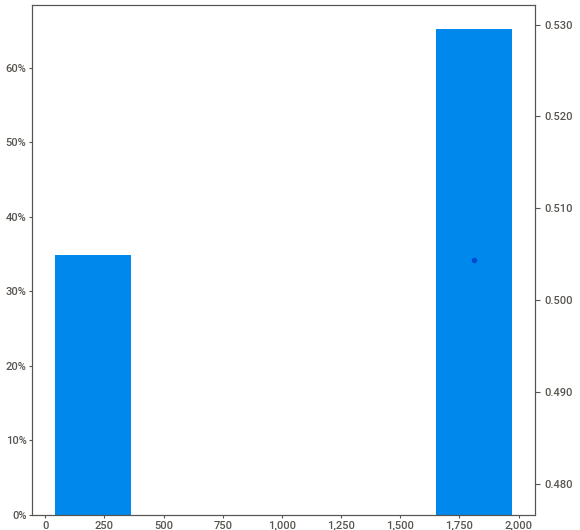
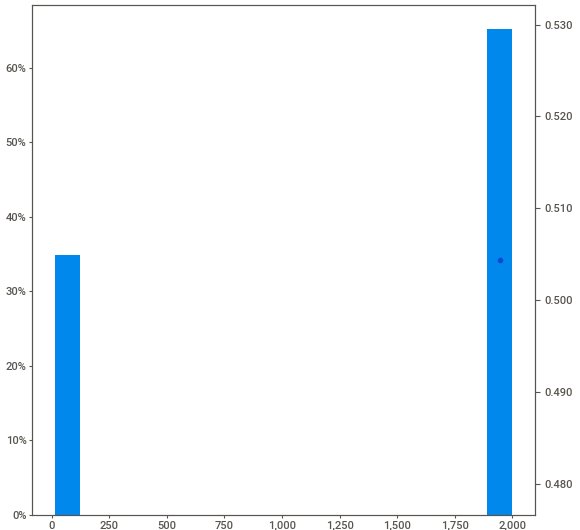
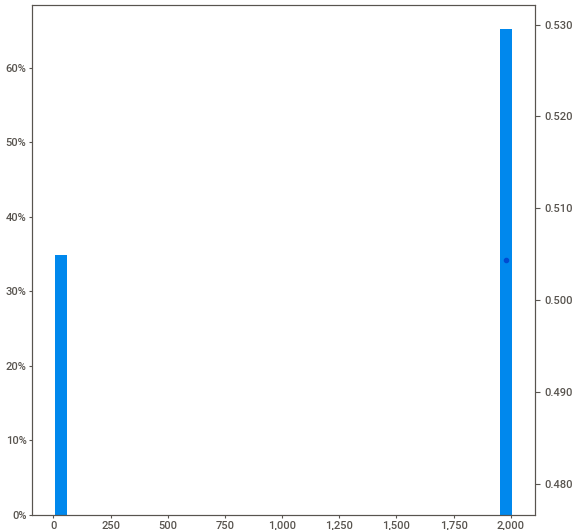
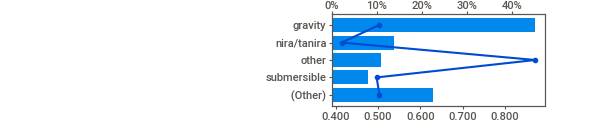
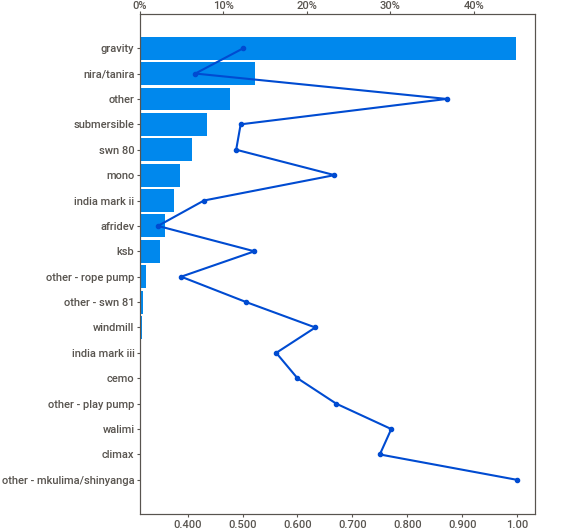
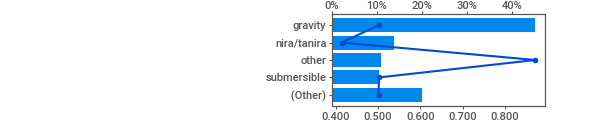
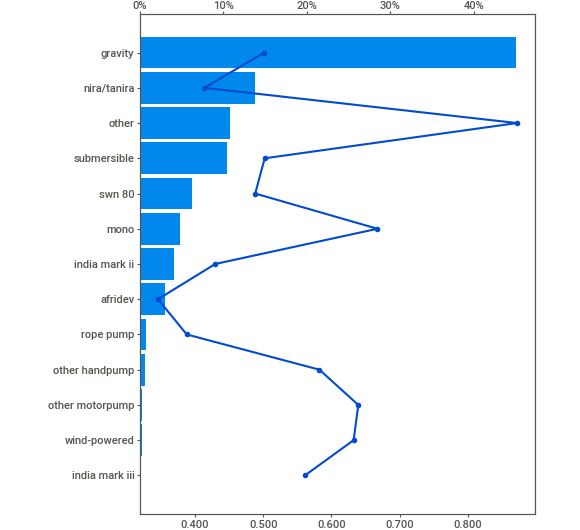
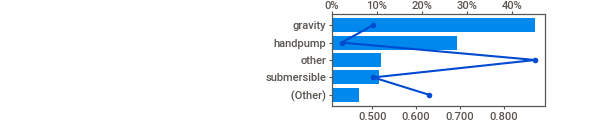
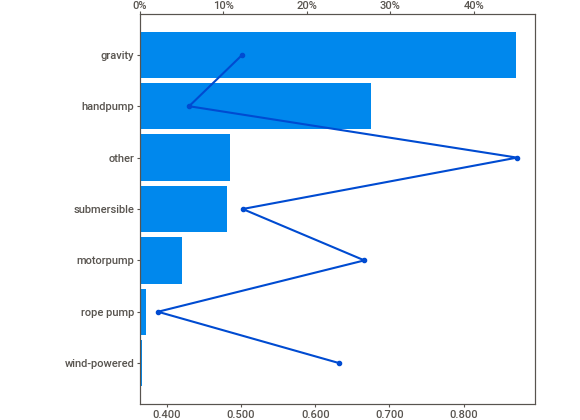
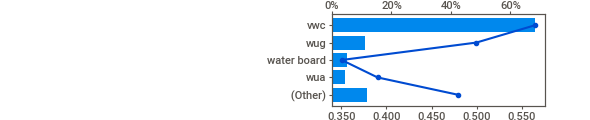
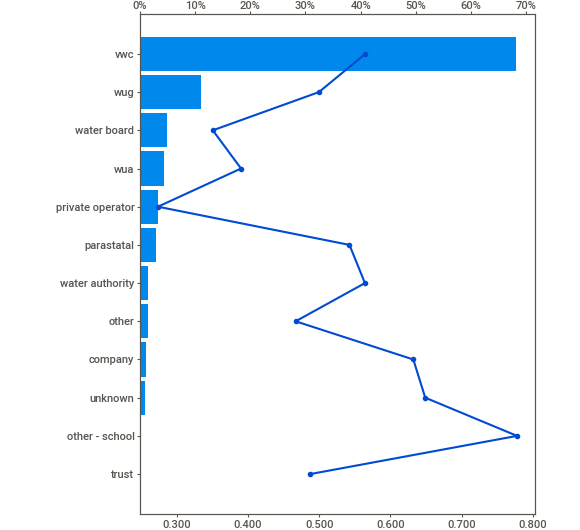
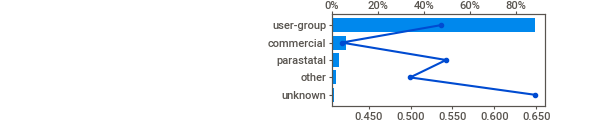
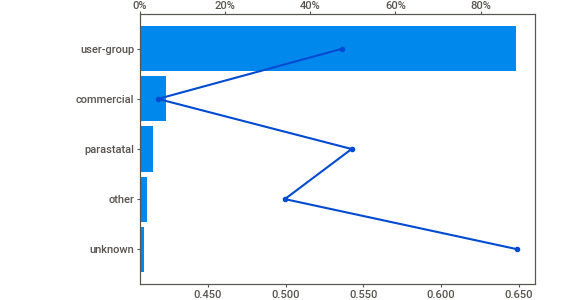
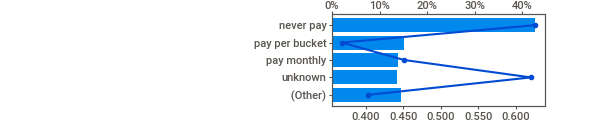
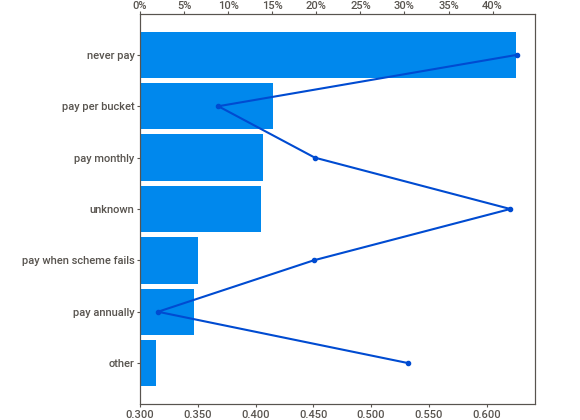
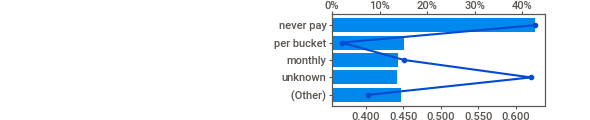
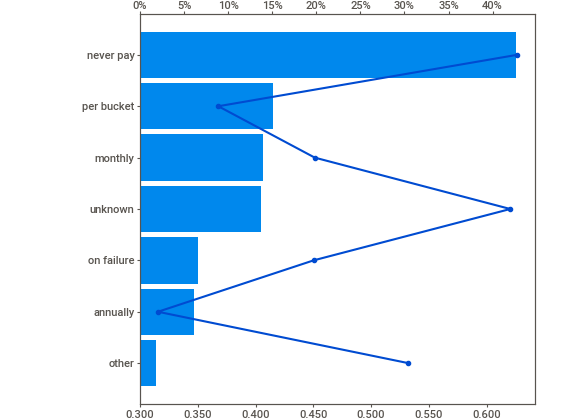
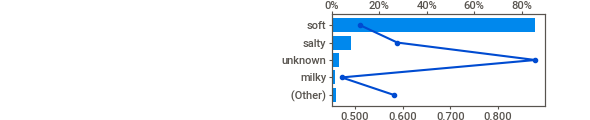
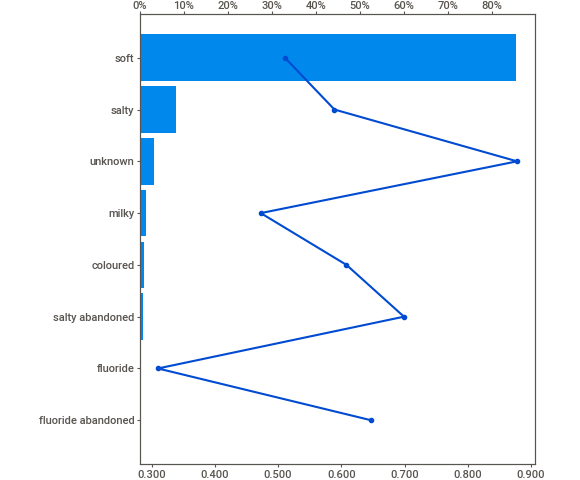
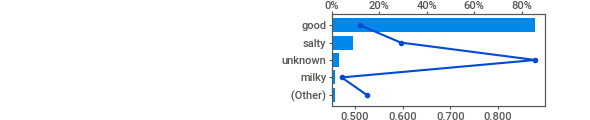
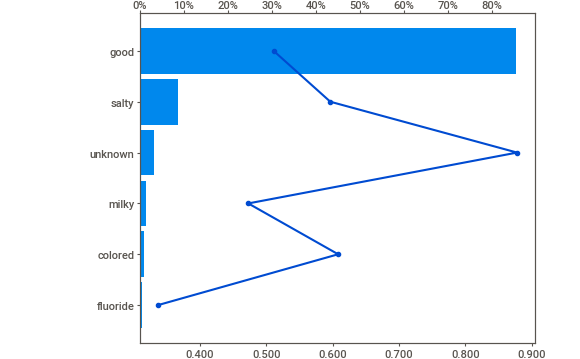
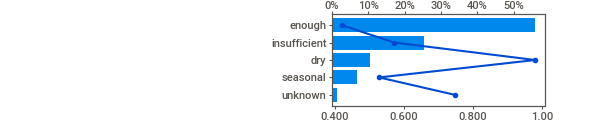
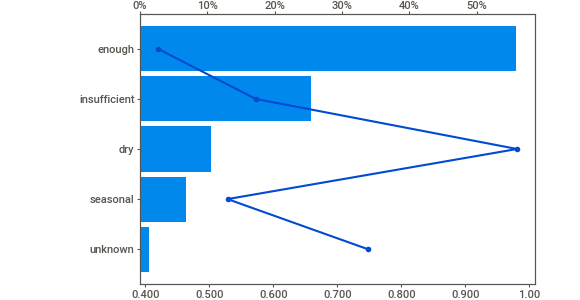
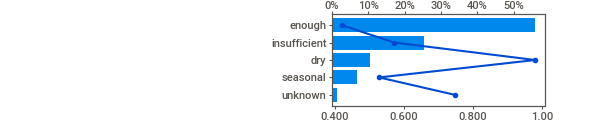
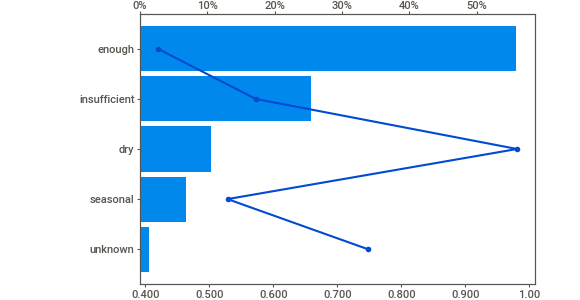
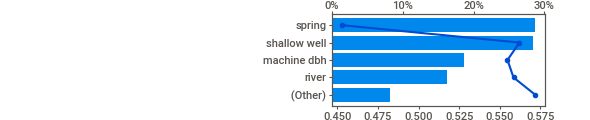
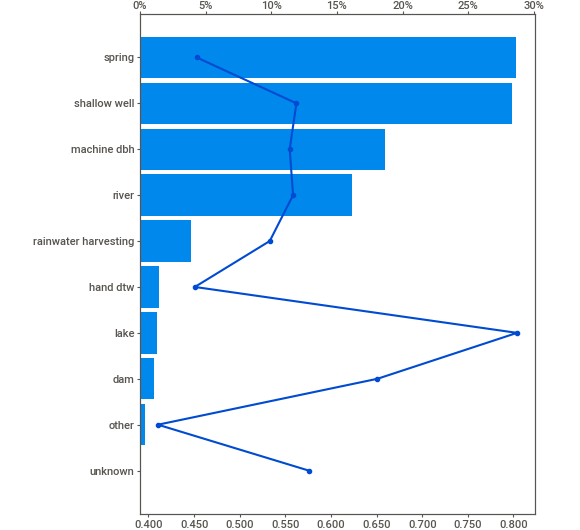
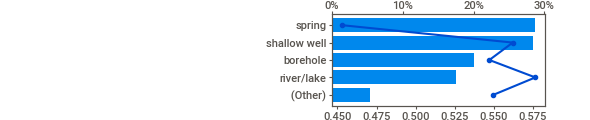
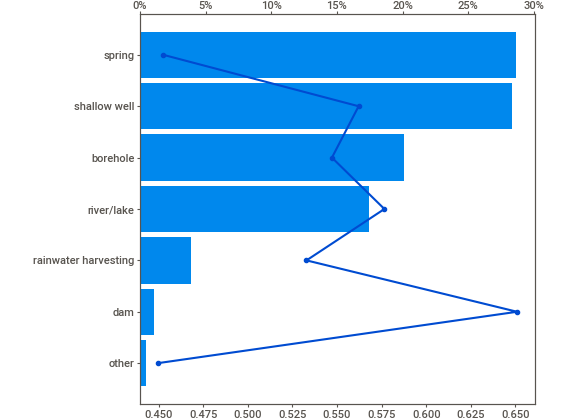
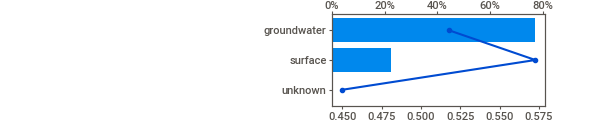
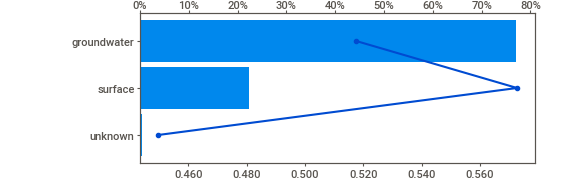
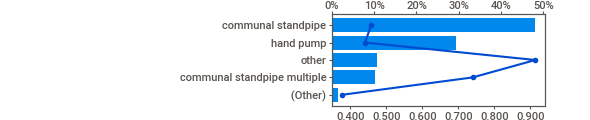
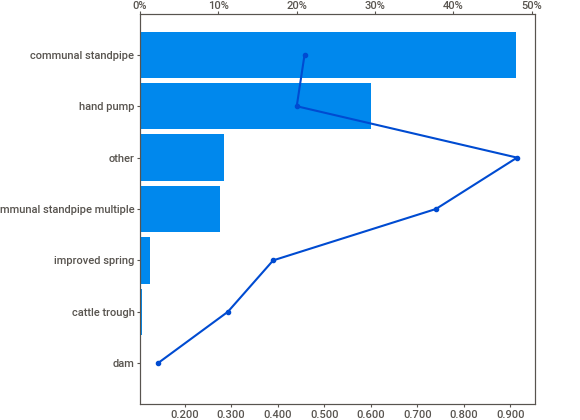
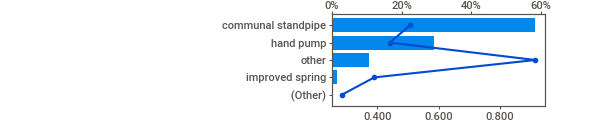
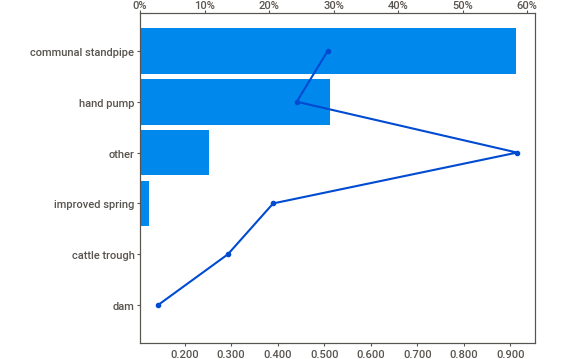
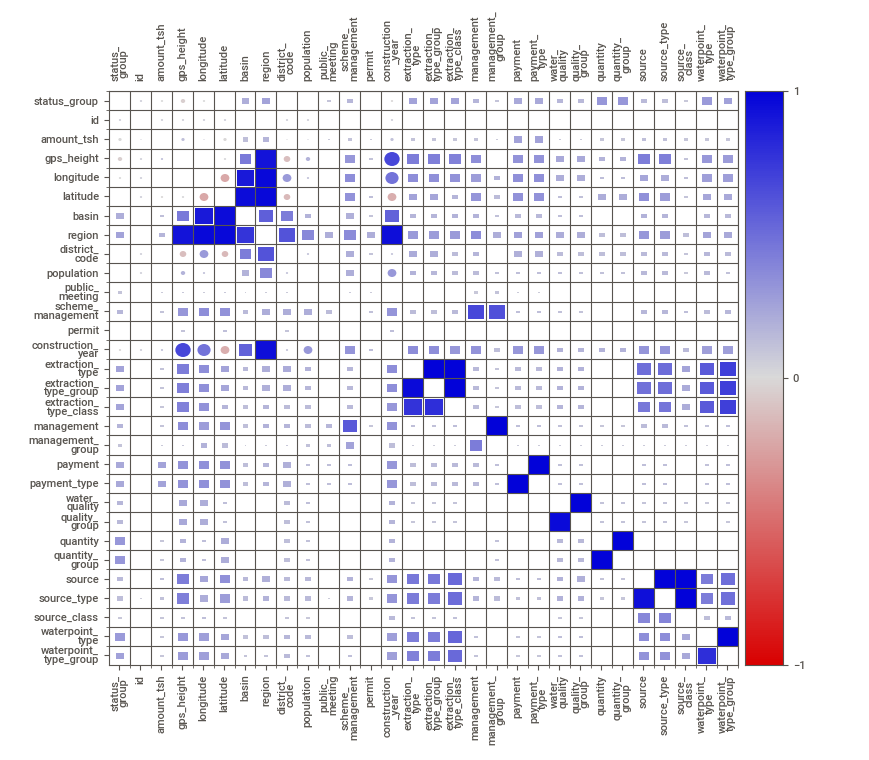
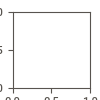

In [ ]:
feature_config = sv.FeatureConfig(force_num="status_group")
my_report_1 = sv.analyze(source = df_w, pairwise_analysis="on", target_feat = 'status_group', feat_cfg=feature_config)
my_report_1.show_notebook()

In [49]:
#Impute the variable construction year on the basis of region and district code

df_w['construction_year'].replace(0.0, np.nan, inplace=True)
df_w["construction_year"].fillna(df_w.groupby(['region', 'district_code'])["construction_year"].transform("median"), inplace=True)
df_w["construction_year"].fillna(df_w.groupby(['region'])["construction_year"].transform("median"), inplace=True)
df_w["construction_year"].fillna(df_w.groupby(['district_code'])["construction_year"].transform("median"), inplace=True)
df_w["construction_year"].fillna(df_w["construction_year"].median(), inplace=True)

In [ ]:
#Check Null Values

df_w.isnull().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
region                      0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint

In [51]:
# A function defined to create features from Date_recorded column
# This comes in handy while using tree based algorithms as those don't support categorical variables

def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$','', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
             'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)

In [52]:
#Use the above function to create additional features from Date column and drop the date column after features are created

add_datepart(df_w, 'date_recorded')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [53]:
#Separate out the list of numerical and categorical features

numerical_features = list(df_w.select_dtypes(exclude=['object']))
categorical_features = list(df_w.select_dtypes(include=['object']))

# Modelling - and - Preparing Data

In [54]:
#Performing Target Encoding for the categorical features

encoder = TargetEncoder()
df_w[categorical_features] = encoder.fit_transform(df_w[categorical_features], df_w['status_group'])

In [56]:
#Separate test and train data

X = df_w.drop('status_group',axis=1)
y = df_w[['status_group']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

Decision Tree Model

In [63]:
#Decision Tree

clf_model_1 = DecisionTreeClassifier()   
clf_model_1.fit(X_train,y_train)
pred = clf_model_1.predict(X_test)

DecisionTreeClassifier()

In [74]:
#Classification Report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      9724
           1       0.75      0.76      0.75      6803
           2       0.36      0.38      0.37      1293

    accuracy                           0.75     17820
   macro avg       0.64      0.64      0.64     17820
weighted avg       0.75      0.75      0.75     17820



Random Forest Model

In [68]:
#Random Forest

clf_model = RandomForestClassifier()   
clf_model.fit(X_train,y_train)
pred_rf = clf_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier()

In [75]:
#Classification Report

print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      9724
           1       0.84      0.79      0.81      6803
           2       0.51      0.36      0.42      1293

    accuracy                           0.81     17820
   macro avg       0.72      0.68      0.69     17820
weighted avg       0.80      0.81      0.80     17820

